In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker

import seaborn as sns

from alive_progress import alive_bar

from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde

import ssa_calc

import astropy.units as u
from astropy.time import Time

# Creating a curve_fit on the temperature data:
from scipy.optimize import curve_fit, fsolve

# # Defining plotting style:
plt.style.use("default")  # Dark background for plots

mpl.rcParams["grid.color"] = "grey"  # Grid color
mpl.rcParams["grid.linestyle"] = "--"  # Grid line style
mpl.rcParams["grid.linewidth"] = 0.5  # Grid line width
mpl.rcParams["grid.alpha"] = 0.5  # Grid transparency

# Setting plt colors:
# Setting plt colors to TU Delft colors (order: blue, red, yellow, green and repeating with different shades):
plt_colors = [
    "#006EB7",
    '#A50034',
    "#64A600",
    "#F97306",
    # Darker colors
    '#1A356E',
    "#E60000",
    '#6CC24A',
    '#FFB81C',
    # More darker colors
    "#000D3A",
    "#9A0000",
    "#B14400",
    "#3D5B00",
]

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Set random seed for reproducibility:
np.random.seed(42)
tf.random.set_seed(42)
# # Temporary test plot to prevent tensorflow from crashing:
# _ = plt.plot([1, 2, 3], [1, 2, 3], color=plt_colors[0])

2023-06-03 11:11:43.293753: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 11:11:44.838590: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-03 11:11:44.838727: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-03 11:11:44.838740: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Num GPUs Available:  1


2023-06-03 11:11:48.396836: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-03 11:11:48.510041: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-03 11:11:48.510350: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
# Loading the data
telem_path = r"../telemetry-files/delfi-pq/delfi-pq-telemetry-2022-01-18-to-2022-03-29.h5"
telem_raw_df = pd.read_hdf(
    telem_path,
    "telem",
)

telem_raw_df.head()

time (utc)     time (jd)  beta (deg)        fe  theta (deg)  \
0  2022-01-18 17:12:17.000  2.459598e+06   32.895989  0.349273   220.506984   
1  2022-01-18 18:41:24.000  2.459598e+06   32.900397  0.349014   197.714357   
2  2022-01-18 18:43:24.000  2.459598e+06   32.901143  0.349090   205.275916   
3  2022-01-18 18:44:24.000  2.459598e+06   32.901391  0.349131   209.056697   
4  2022-01-18 18:45:24.000  2.459598e+06   32.901552  0.349173   212.837490   

   theta_T (deg)  battery GG temperature (deg C)  \
0     337.637846                            -4.2   
1     314.891798                            -0.7   
2     322.439748                            -1.9   
3     326.213181                            -2.4   
4     329.986271                            -3.0   

   battery TMP20 temperature (deg C)  solar panel Yp temperature (deg C)  \
0                               -3.2                               -24.7   
1                                0.8                               -18.5   
2                                0.0                               -20.9   
3                               -0.2                               -21.9   
4                               -1.3                               -23.0   

   solar panel Ym temperature (deg C)  solar panel Xp temperature (deg C)  \
0                               -26.4                               -25.0   
1                               -20.7                               -18.6   
2                               -22.7                               -20.8   
3                               -23.8                               -22.1   
4                               -24.9                               -23.2   

   solar panel Xm temperature (deg C)  MCU temperature (deg C)  
0                               -23.4                    -12.2  
1                               -17.8                     -7.4  
2                               -19.9                     -8.9  
3                               -20.9                     -9.8  
4                               -21.9                    -11.2

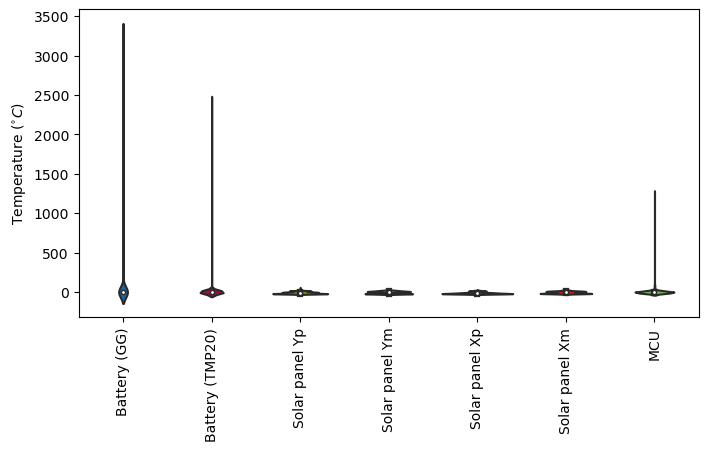

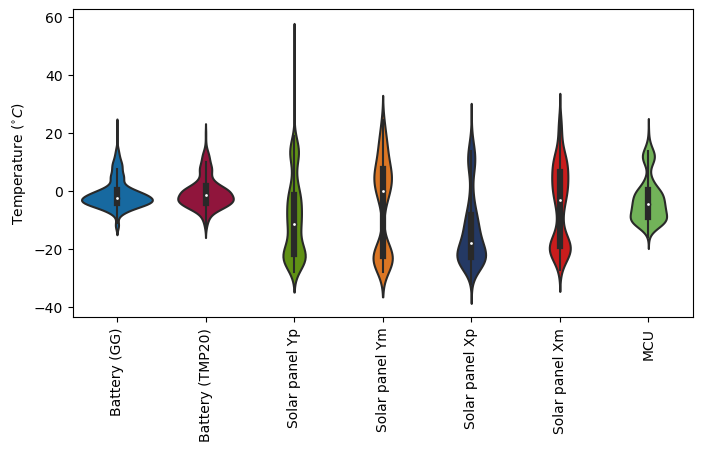

In [3]:
# Plotting the temperature data in a violin plot:
plt.figure(figsize=(8, 4))
ax = sns.violinplot(data=telem_raw_df.iloc[:, 6:], palette=plt_colors[0:7])
ax.set_ylabel("Temperature $(^{\circ}C)$")
_ = ax.set_xticklabels(["Battery (GG)", "Battery (TMP20)", "Solar panel Yp", "Solar panel Ym", "Solar panel Xp", "Solar panel Xm", "MCU"], rotation=90)
plt.show()

# Removing obvious anomalies:
telem_df = telem_raw_df.copy(deep=True)
for i, row in telem_df.iterrows():
    for j, item in row.iloc[6:].items():
        if not -40 < item < 70:
            telem_df.loc[i, j] = np.nan

# Plotting the temperature data in a violin plot:
plt.figure(figsize=(8, 4))
ax = sns.violinplot(data=telem_df.iloc[:, 6:], palette=plt_colors[0:7])
ax.set_ylabel("Temperature $(^{\circ}C)$")
_ = ax.set_xticklabels(["Battery (GG)", "Battery (TMP20)", "Solar panel Yp", "Solar panel Ym", "Solar panel Xp", "Solar panel Xm", "MCU"], rotation=90)
plt.show()

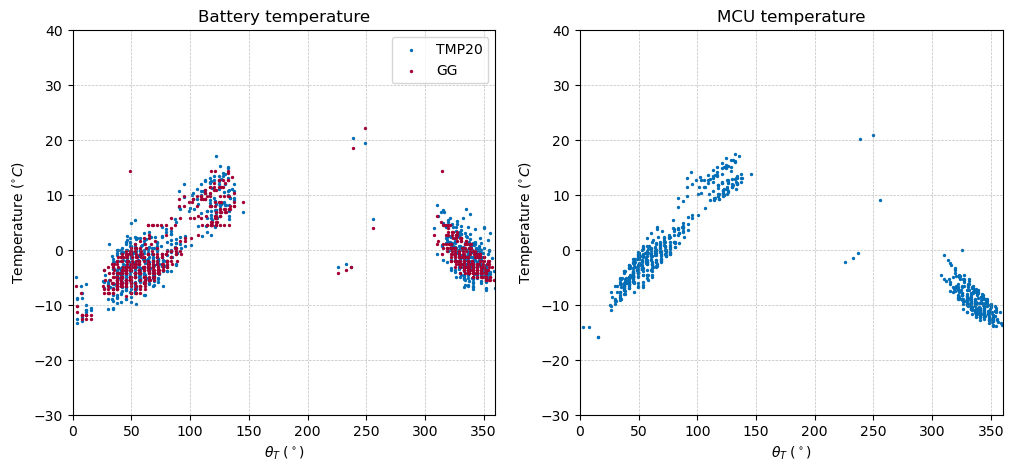

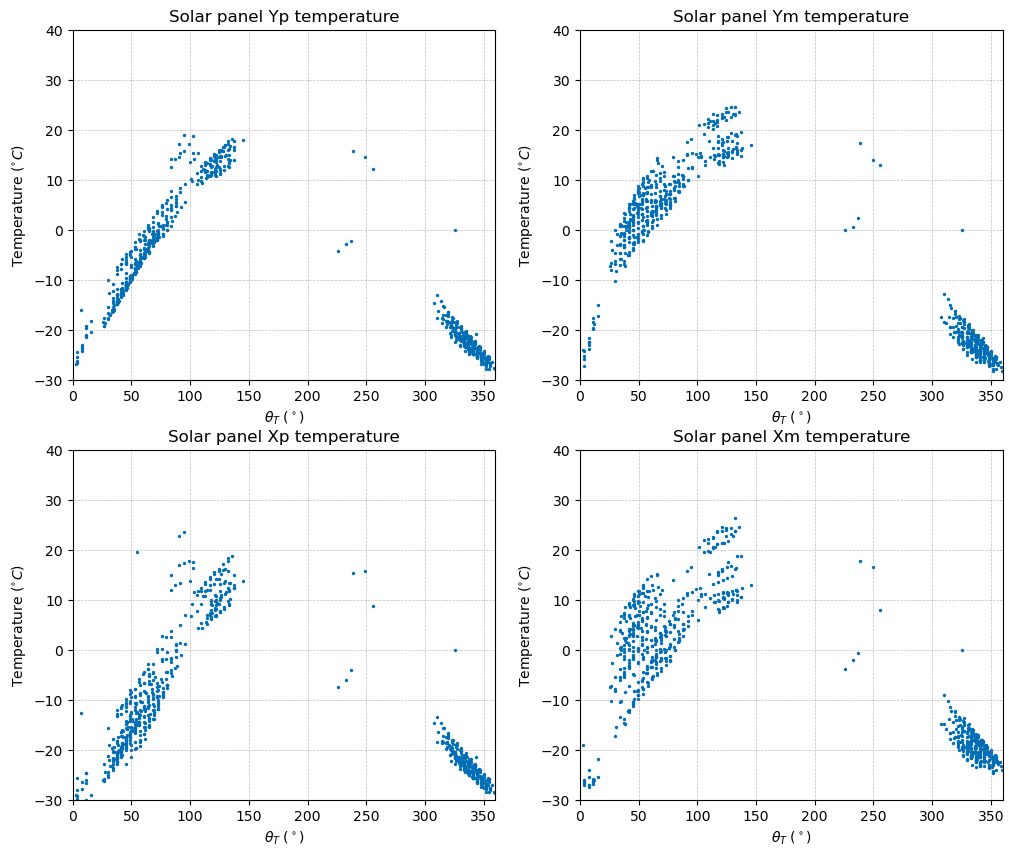

In [50]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(
    telem_df["theta_T (deg)"],
    telem_df["battery TMP20 temperature (deg C)"],
    s=2,
    color=plt_colors[0],
    label="TMP20"
)
plt.scatter(
    telem_df["theta_T (deg)"],
    telem_df["battery GG temperature (deg C)"],
    s=2,
    color=plt_colors[1],
    label="GG"
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel("Temperature $(^{\circ}C)$")
plt.legend()
plt.title("Battery temperature")
plt.grid()
plt.xlim(0, 360)
plt.ylim(-30, 40)
plt.subplot(1, 2, 2)
plt.scatter(
    telem_df["theta_T (deg)"],
    telem_df["MCU temperature (deg C)"],
    s=2,
    color=plt_colors[0],
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel("Temperature $(^{\circ}C)$")
plt.title("MCU temperature")
plt.grid()
plt.xlim(0, 360)
plt.ylim(-30, 40)

plt.show()




plt.figure(figsize=(12,10))
plt.subplot(2, 2, 1)
plt.scatter(
    telem_df["theta_T (deg)"],
    telem_df["solar panel Yp temperature (deg C)"],
    s=2,
    color=plt_colors[0],
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel("Temperature $(^{\circ}C)$")
plt.title("Solar panel Yp temperature")
plt.grid()
plt.xlim(0, 360)
plt.ylim(-30, 40)

plt.subplot(2, 2, 2)
plt.scatter(
    telem_df["theta_T (deg)"],
    telem_df["solar panel Ym temperature (deg C)"],
    s=2,
    color=plt_colors[0],
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel("Temperature $(^{\circ}C)$")
plt.title("Solar panel Ym temperature")
plt.grid()
plt.xlim(0, 360)
plt.ylim(-30, 40)

plt.subplot(2, 2, 3)
plt.scatter(
    telem_df["theta_T (deg)"],
    telem_df["solar panel Xp temperature (deg C)"],
    s=2,
    color=plt_colors[0],
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel("Temperature $(^{\circ}C)$")
plt.title("Solar panel Xp temperature")
plt.grid()
plt.xlim(0, 360)
plt.ylim(-30, 40)

plt.subplot(2, 2, 4)
plt.scatter(
    telem_df["theta_T (deg)"],
    telem_df["solar panel Xm temperature (deg C)"],
    s=2,
    color=plt_colors[0],
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel("Temperature $(^{\circ}C)$")
plt.title("Solar panel Xm temperature")
plt.grid()
plt.xlim(0, 360)
plt.ylim(-30, 40)

plt.show()


In [70]:
def plot_model(theta_T_data=None, theta_T_model=None, temp_data=None, temp_model=None, limit_axis=None):
    if limit_axis is None:
        xlim = [0, 360]
        ylim = [np.nanmin(telem_df.iloc[:, 6:].values) - 5, np.nanmax(telem_df.iloc[:, 6:].values) + 5]

    else:
        xlim = limit_axis[0]
        ylim = limit_axis[1]


    plt.figure(figsize=(10,20))
    plt.subplot(4, 2, 1)
    if theta_T_data is not None:
        plt.scatter(
            theta_T_data,
            temp_data[:, 0],
            color=plt_colors[0],
            s=2,
            label="Data",
        )
    if theta_T_model is not None:
        plt.plot(
            theta_T_model,
            temp_model[:, 0],
            color=plt_colors[1],
            label="Base model"
        )
    plt.legend()
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"Temperature ($^\circ C$)")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Battery GG temperature")
    plt.grid()

    plt.subplot(4, 2, 2)
    if theta_T_data is not None:
        plt.scatter(
            theta_T_data,
            temp_data[:, 1],
            color=plt_colors[0],
            s=2,
            label="Data",
        )
    if theta_T_model is not None:
        plt.plot(
            theta_T_model,
            temp_model[:, 0],
            color=plt_colors[1],
            label="Base model"
        )
    plt.legend()
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"Temperature ($^\circ C$)")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Battery TMP20 temperature")
    plt.grid()

    plt.subplot(4, 2, 3)
    if theta_T_data is not None:
        plt.scatter(
            theta_T_data,
            temp_data[:, 2],
            color=plt_colors[0],
            s=2,
            label="Data",
        )
    if theta_T_model is not None:
        plt.plot(
            theta_T_model,
            temp_model[:, 1],
            color=plt_colors[1],
            label="Base model"
        )
    plt.legend()
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"Temperature ($^\circ C$)")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Solar panel Yp temperature")
    plt.grid()

    plt.subplot(4, 2, 4)
    if theta_T_data is not None:
        plt.scatter(
            theta_T_data,
            temp_data[:, 3],
            color=plt_colors[0],
            s=2,
            label="Data",
        )
    if theta_T_model is not None:
        plt.plot(
            theta_T_model,
            temp_model[:, 2],
            color=plt_colors[1],
            label="Base model"
        )
    plt.legend()
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"Temperature ($^\circ C$)")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Solar panel Ym temperature")
    plt.grid()

    plt.subplot(4, 2, 5)
    if theta_T_data is not None:
        plt.scatter(
            theta_T_data,
            temp_data[:, 4],
            color=plt_colors[0],
            s=2,
            label="Data",
        )
    if theta_T_model is not None:
        plt.plot(
            theta_T_model,
            temp_model[:, 3],
            color=plt_colors[1],
            label="Base model"
        )
    plt.legend()
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"Temperature ($^\circ C$)")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Solar panel Xp temperature")
    plt.grid()

    plt.subplot(4, 2, 6)
    if theta_T_data is not None:
        plt.scatter(
            theta_T_data,
            temp_data[:, 5],
            color=plt_colors[0],
            s=2,
            label="Data",
        )
    if theta_T_model is not None:
        plt.plot(
            theta_T_model,
            temp_model[:, 4],
            color=plt_colors[1],
            label="Base model"
        )
    plt.legend()
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"Temperature ($^\circ C$)")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Solar panel Xm temperature")
    plt.grid()

    plt.subplot(4, 2, 7)
    if theta_T_data is not None:
        plt.scatter(
            theta_T_data,
            temp_data[:, 6],
            color=plt_colors[0],
            s=2,
            label="Data",
        )
    if theta_T_model is not None:
        plt.plot(
            theta_T_model,
            temp_model[:, 5],
            color=plt_colors[1],
            label="Base model"
        )
    plt.legend()
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"Temperature ($^\circ C$)")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("MCU temperature")
    plt.grid()

    plt.tight_layout()
    plt.show()
    plt.close()

In [52]:
# Function to calculate the kernel density estimate (KDE) of a given dataset:
def kde(data, bins=250, plot_kde=True, print_stats=True, return_kde=False, return_stats=False, plt_title=None):
    """
    Function to calculate the kernel density estimate (KDE) of a given dataset.

    :param data: Dataset to calculate the KDE of.
    :param bins: Number of bins to use for the KDE.
    :param plot_kde: Boolean to indicate whether to plot the KDE.
    :param print_stats: Boolean to indicate whether to print the mean and standard deviation of the KDE.
    :param return_kde: Boolean to indicate whether to return the KDE and bin centers.

    :return: If return_kde is True, the KDE and bin centers are returned.
    """


    kde = np.empty(shape=(data.shape[1], bins), dtype=np.float64)
    bin_centers = np.empty(shape=(data.shape[1], bins), dtype=np.float64)
    for i in range(data.shape[1]):
        kde_func = gaussian_kde(data[:, i])
        bin_centers[i] = np.linspace(np.min(data[:, i]), np.max(data[:, i]), bins)
        kde[i, :] = kde_func(bin_centers[i])

    if plot_kde:
        plt.figure(figsize=(5, 5))
        plt.plot(
            bin_centers[0],
            kde[0],
            color=plt_colors[0],
            label="battery",
        )
        plt.plot(
            bin_centers[1],
            kde[1],
            color=plt_colors[1],
            label="solar panel Yp",
        )
        plt.plot(
            bin_centers[2],
            kde[2],
            color=plt_colors[2],
            label="solar panel Ym",
        )
        plt.plot(
            bin_centers[3],
            kde[3],
            color=plt_colors[3],
            label="solar panel Xp",
        )
        plt.plot(
            bin_centers[4],
            kde[4],
            color=plt_colors[4],
            label="solar panel Xm",
        )
        plt.plot(
            bin_centers[5],
            kde[5],
            color=plt_colors[5],
            label="MCU",
        )
        plt.xlabel(r"Error ($^\circ$C)")
        plt.ylabel("Probability density")
        if plt_title is None:
            plt.title("Kernel density estimate of the errors")
        else:
            plt.title(plt_title)
        plt.legend()
        plt.grid()
        plt.show()

    if print_stats:
        print("Battery:")
        print(f"Mean: {np.mean(data[:, 0]):.2f} degC Std: {np.std(data[:, 0]):.2f} degC (area: {np.trapz(kde[0], bin_centers[0]):.2f})")
        print("Solar panel Yp:")
        print(f"Mean: {np.mean(data[:, 1]):.2f} degC Std: {np.std(data[:, 1]):.2f} degC (area: {np.trapz(kde[1], bin_centers[1]):.2f})")
        print("Solar panel Ym:")
        print(f"Mean: {np.mean(data[:, 2]):.2f} degC Std: {np.std(data[:, 2]):.2f} degC (area: {np.trapz(kde[2], bin_centers[2]):.2f})")
        print("Solar panel Xp:")
        print(f"Mean: {np.mean(data[:, 3]):.2f} degC Std: {np.std(data[:, 3]):.2f} degC (area: {np.trapz(kde[3], bin_centers[3]):.2f})")
        print("Solar panel Xm:")
        print(f"Mean: {np.mean(data[:, 4]):.2f} degC Std: {np.std(data[:, 4]):.2f} degC (area: {np.trapz(kde[4], bin_centers[4]):.2f})")
        print("MCU:")
        print(f"Mean: {np.mean(data[:, 5]):.2f} degC Std: {np.std(data[:, 5]):.2f} degC (area: {np.trapz(kde[5], bin_centers[5]):.2f})")

        print("\n")
        print("Probability of error within 1 degC:")
        error_bracket = np.empty(shape=(data.shape[1],), dtype=np.float64)
        for i in range(data.shape[1]):
            error_bracket[i] = np.trapz(kde[i][np.abs(bin_centers[i]) <= 1], bin_centers[i][np.abs(bin_centers[i]) <= 1])
        print(f"Battery: {error_bracket[0]:.2f}")
        print(f"Solar panel Yp: {error_bracket[1]:.2f}")
        print(f"Solar panel Ym: {error_bracket[2]:.2f}")
        print(f"Solar panel Xp: {error_bracket[3]:.2f}")
        print(f"Solar panel Xm: {error_bracket[4]:.2f}")
        print(f"MCU: {error_bracket[5]:.2f}")


    return_vals = []

    if return_kde:
        return_vals.append((kde, bin_centers))
    
    if return_stats:
        return_vals.append((np.mean(data, axis=0), np.std(data, axis=0), error_bracket))

    if len(return_vals) != 0:
        return return_vals

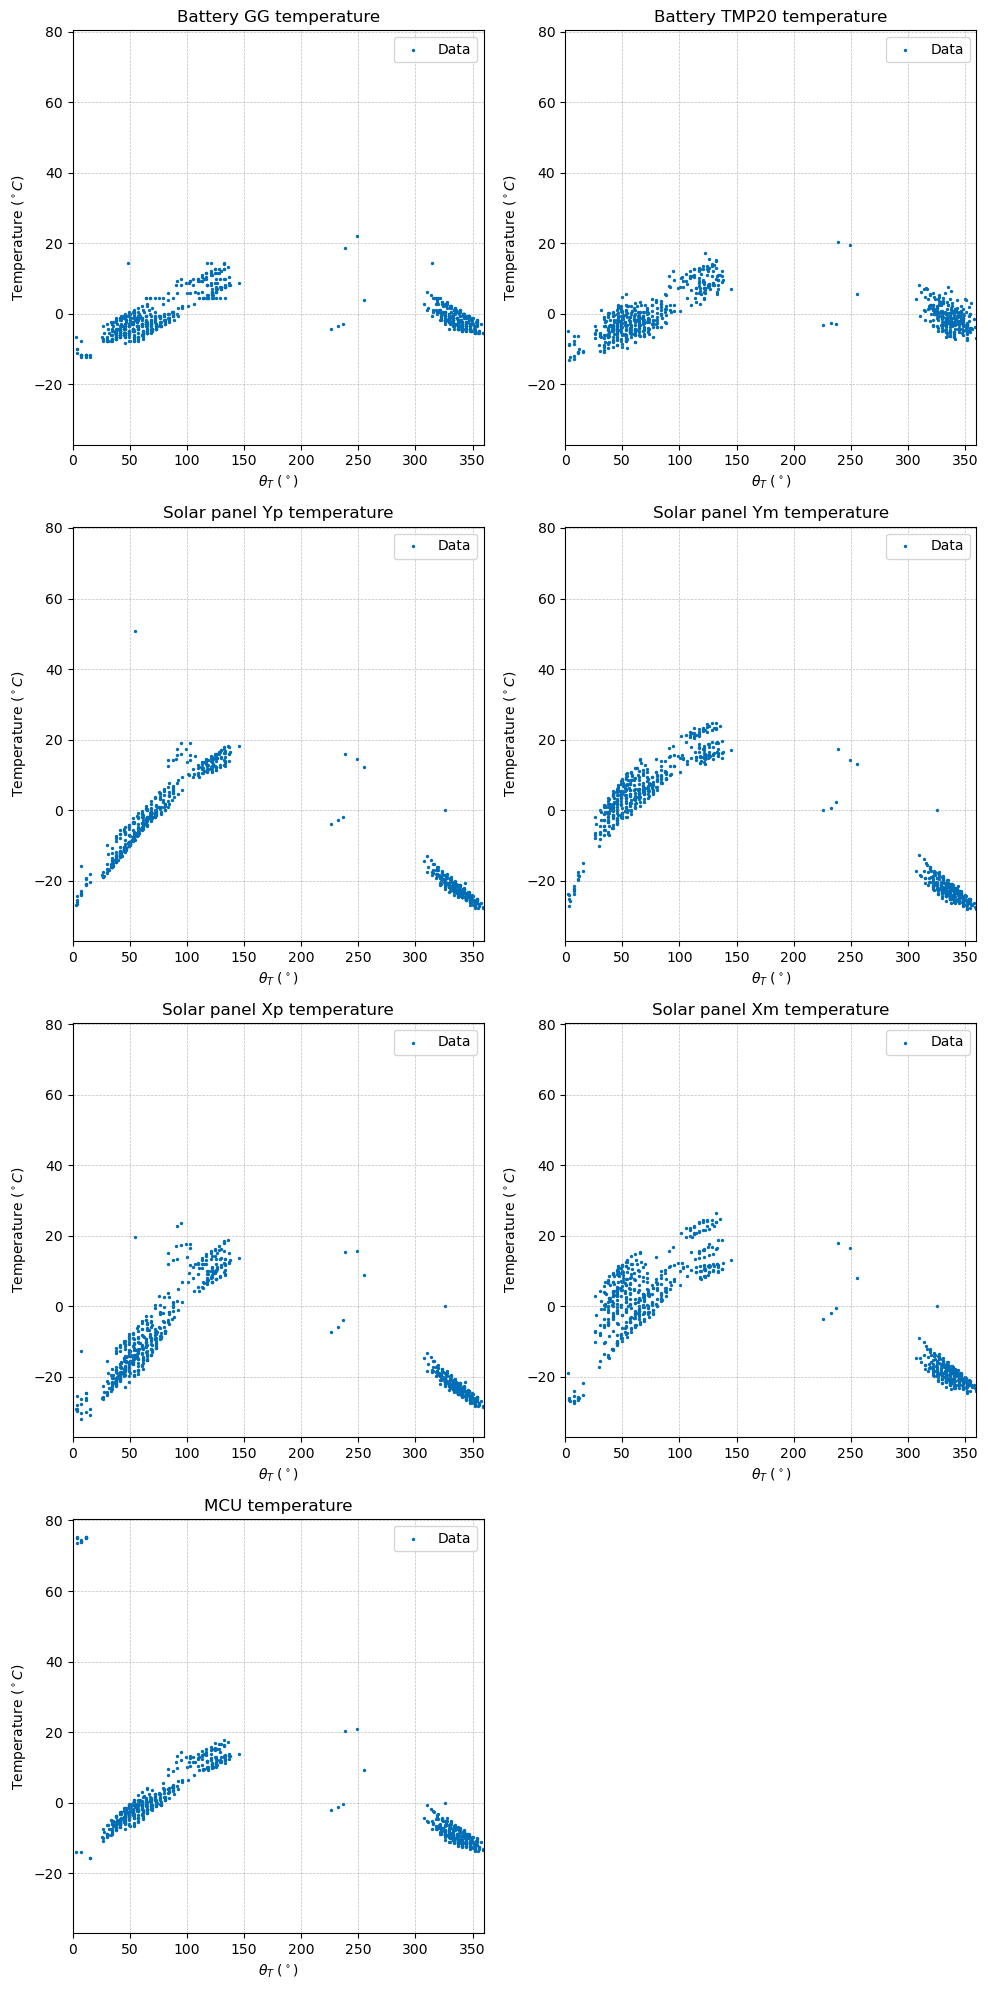

In [53]:
plot_model(
    theta_T_data=telem_df["theta_T (deg)"].values,
    temp_data=telem_df.iloc[:, 6:].values,
)

In [54]:
# Testing predictions without cleaning up the data further:
def normalize_datasets(df, min_temp, max_temp):
    df = df.copy()
    df.iloc[:, 6:] = (
        df.iloc[:, 6:] - min_temp
    ) / (max_temp - min_temp)

    return df

# Splitting the data into training and testing sets:
train_df = telem_df.iloc[:int(0.8 * len(telem_df))]
test_df = telem_df.iloc[int(0.8 * len(telem_df)):]

# Normalizing the data:\
min_temp = np.nanmin(train_df.iloc[:, 6:].values)
max_temp = np.nanmax(train_df.iloc[:, 6:].values)

train_norm_df = normalize_datasets(train_df, min_temp, max_temp)
test_norm_df = normalize_datasets(test_df, min_temp, max_temp)

# Removing rows with any nan values:
train_norm_df = train_norm_df.dropna(how="any").reset_index(drop=True)
test_norm_df = test_norm_df.dropna(how="any").reset_index(drop=True)

In [60]:
def window_data_base(df, window_size, delfi_pq):
    columns = np.concatenate((
        ["theta_T"],
        ["illumination " + str(i) for i in range(window_size)],
        ["battery temp"],
        ["solar panel Yp temp"],
        ["solar panel Ym temp"],
        ["solar panel Xp temp"],
        ["solar panel Xm temp"],
        ["MCU temp"]
    ))

    window_df = pd.DataFrame(columns=columns, index=range(len(df)))

    with alive_bar(len(df), theme="classic", force_tty=True) as bar:
        for i in range(len(df)):
            window_df.loc[i, "theta_T"] = np.float64(df.loc[i, "theta_T (deg)"])
            time = Time(df.loc[i, "time (utc)"], format="iso", scale="utc")
            for j in range(window_size):
                calc_time = time - (window_size - j) * u.min
                beta, fe, theta, theta_T = delfi_pq.calc_beta_fe_theta(calc_time)
                if theta_T.value < 2 * np.pi * (1 - fe.value):
                    window_df.loc[i, "illumination " + str(j)] = np.int64(1)
                else:
                    window_df.loc[i, "illumination " + str(j)] = np.int64(0)

            window_df.loc[i, "battery temp"] = df.loc[i, "battery TMP20 temperature (deg C)"]
            window_df.loc[i, "solar panel Yp temp"] = df.loc[i, "solar panel Yp temperature (deg C)"]
            window_df.loc[i, "solar panel Ym temp"] = df.loc[i, "solar panel Ym temperature (deg C)"]
            window_df.loc[i, "solar panel Xp temp"] = df.loc[i, "solar panel Xp temperature (deg C)"]
            window_df.loc[i, "solar panel Xm temp"] = df.loc[i, "solar panel Xm temperature (deg C)"]
            window_df.loc[i, "MCU temp"] = df.loc[i, "MCU temperature (deg C)"]
            bar()

    return window_df



In [56]:
DELFI_PQ_POS_INTERP_PATH = r"../orbit-propagation/interpolators/delfi-pq-pos-interpolator-2022-01-18-to-2022-10-23.pkl"
DELFI_PQ_VEL_INTERP_PATH = r"../orbit-propagation/interpolators/delfi-pq-vel-interpolator-2022-01-18-to-2022-10-23.pkl"
delfi_pq = ssa_calc.Satellite(DELFI_PQ_POS_INTERP_PATH, DELFI_PQ_VEL_INTERP_PATH)

Loading interpolators from pickle files...
Interpolators loaded.


In [63]:
train_base_df = window_data_base(train_norm_df, 96, delfi_pq)
test_base_df = window_data_base(test_norm_df, 96, delfi_pq)

# Convert the datatypes of all columns of the dataframe to float64 except the illumination columns:
for col in train_base_df.columns:
    if "illumination" not in col:
        train_base_df[col] = train_base_df[col].astype(np.float64)
        test_base_df[col] = test_base_df[col].astype(np.float64)
    else:
        train_base_df[col] = train_base_df[col].astype(np.int64)
        test_base_df[col] = test_base_df[col].astype(np.int64)

# Saving the data:
DF_SAVE_PATH = r"./base-df.h5"
train_base_df.to_hdf(DF_SAVE_PATH, key="train", mode="w")
test_base_df.to_hdf(DF_SAVE_PATH, key="test", mode="a")

[========================================] 590/590 [100%] in 8:56.8 (1.10/s)                                            
[========================================] 149/149 [100%] in 2:13.4 (1.11/s)                                            


In [11]:
# Loading the data:
DF_SAVE_PATH = r"./base-df.h5"
train_base_df = pd.read_hdf(DF_SAVE_PATH, key="train")
test_base_df = pd.read_hdf(DF_SAVE_PATH, key="test")

In [64]:
def create_model(layers, optimizer, loss_function, metric_function, input_shape=(None, 1), output_shape=6):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
    recommended_device = "/GPU:0"
    for i, layer in enumerate(layers):
        if layer.get("type") == "LSTM":
            if i < len(layers) - 1:
                if layers[i + 1].get("type") == "LSTM":
                    model.add(
                        tf.keras.layers.LSTM(
                            layer.get("units"),
                            activation=layer.get("activation"),
                            return_sequences=True,
                        )
                    )
                else:
                    model.add(
                        tf.keras.layers.LSTM(
                            layer.get("units"),
                            activation=layer.get("activation"),
                            return_sequences=False,
                        )
                    )
            else:
                model.add(
                    tf.keras.layers.LSTM(
                        layer.get("units"),
                        activation=layer.get("activation"),
                        return_sequences=False,
                    )
                )
            if layer.get("activation") == "relu":
                recommended_device = "/CPU:0"
        elif layer.get("type") == "Dense":
            model.add(
                tf.keras.layers.Dense(
                    layer.get("units"), activation=layer.get("activation"),
                )
            )
        else:
            raise ValueError("Invalid layer type")
    model.add(tf.keras.layers.Dense(output_shape, activation="linear"))

    model.compile(
        optimizer=optimizer,
        loss=loss_function,
        metrics=[metric_function],
    )
    return model, recommended_device

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 256)         264192    
                                                                 
 lstm_1 (LSTM)               (None, None, 256)         525312    
                                                                 
 lstm_2 (LSTM)               (None, None, 128)         197120    
                                                                 
 lstm_3 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_4 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_5 (LSTM)               (None, None, 32)          12416     
                                                                 
 lstm_6 (LSTM)               (None, 16)                3

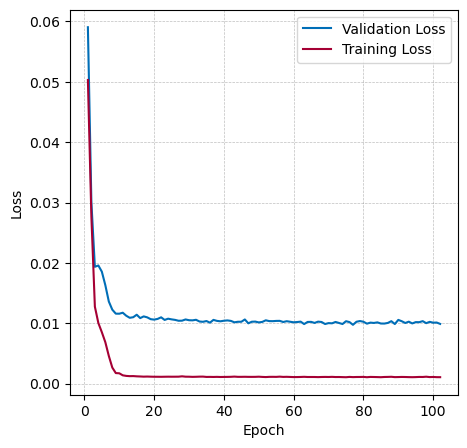

In [65]:
model_base_layers = np.empty(shape=(7), dtype=dict,)
model_base_layers[0] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
model_base_layers[1] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
model_base_layers[2] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
model_base_layers[3] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
model_base_layers[4] = {
    "type": "LSTM",
    "units": 64,
    "activation": "tanh",
}
model_base_layers[5] = {
    "type": "LSTM",
    "units": 32,
    "activation": "tanh",
}
model_base_layers[6] = {
    "type": "LSTM",
    "units": 16,
    "activation": "tanh",
}

# Creating the training and testing numpy arrays:
train_base_x = np.empty(shape=(len(train_base_df), 96, 1), dtype=np.int64)
train_base_y = np.empty(shape=(len(train_base_df), 6), dtype=np.float64)

for i, row in train_base_df.iterrows():
    train_base_x[i, :, 0] = row.iloc[1:97].values
    train_base_y[i, :] = row.iloc[97:].values

test_base_x = np.empty(shape=(len(test_base_df), 96, 1), dtype=np.int64)
test_base_y = np.empty(shape=(len(test_base_df), 6), dtype=np.float64)

for i, row in test_base_df.iterrows():
    test_base_x[i, :, 0] = row.iloc[1:97].values
    test_base_y[i, :] = row.iloc[97:].values

model_base, recommended_device = create_model(
    model_base_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
)

model_base.summary()

with tf.device(recommended_device):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=25,
        restore_best_weights=True,
    )

    history_97 = model_base.fit(
        train_base_x,
        train_base_y,
        epochs=250,
        validation_data=(test_base_x, test_base_y),
        callbacks=[early_stopping],
    )

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_97.history["loss"]), len(history_97.history["loss"])),
    history_97.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_97.history["loss"]), len(history_97.history["loss"])),
    history_97.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [66]:
# Creating illumination data for a full orbit
start_time = Time("2022-01-27 18:33:00", format="iso", scale="utc")
end_time = start_time + 94 * u.min

start = delfi_pq.calc_beta_fe_theta(start_time)
end = delfi_pq.calc_beta_fe_theta(end_time)

print(start[3].to(u.deg))
print(end[3].to(u.deg))

# Artificial orbit
artificial_df = pd.DataFrame(columns=test_base_df.columns, index=range(95))
time = start_time
with alive_bar(95, theme='classic', force_tty=True) as bar:
    for i in range(95):
        beta, fe, theta, theta_T = delfi_pq.calc_beta_fe_theta(time)
        artificial_df.iloc[i, 0] = theta_T.to(u.deg).value
        for j in range(96):
            calc_time = time - (96 - j) * u.min
            beta, fe, theta, theta_T = delfi_pq.calc_beta_fe_theta(calc_time)
            if theta_T.value < 2 * np.pi * (1 - fe.value):
                artificial_df.loc[i, "illumination " + str(j)] = 1
            else:
                artificial_df.loc[i, "illumination " + str(j)] = 0
        
        time += 1 * u.min

        bar()

1.6760463185899401 deg
357.3887434576583 deg
[========================================] 95/95 [100%] in 1:24.6 (1.12/s)                                              


In [67]:
artificial_x = np.empty(shape=(95, 96, 1), dtype=np.int64)
artificial_x[:, :, 0] = artificial_df.iloc[:, 1:97].values
artificial_y = model_base.predict(artificial_x)
artificial_df.iloc[:, 97:] = artificial_y

3/3 [==============================] - 3s 52ms/step


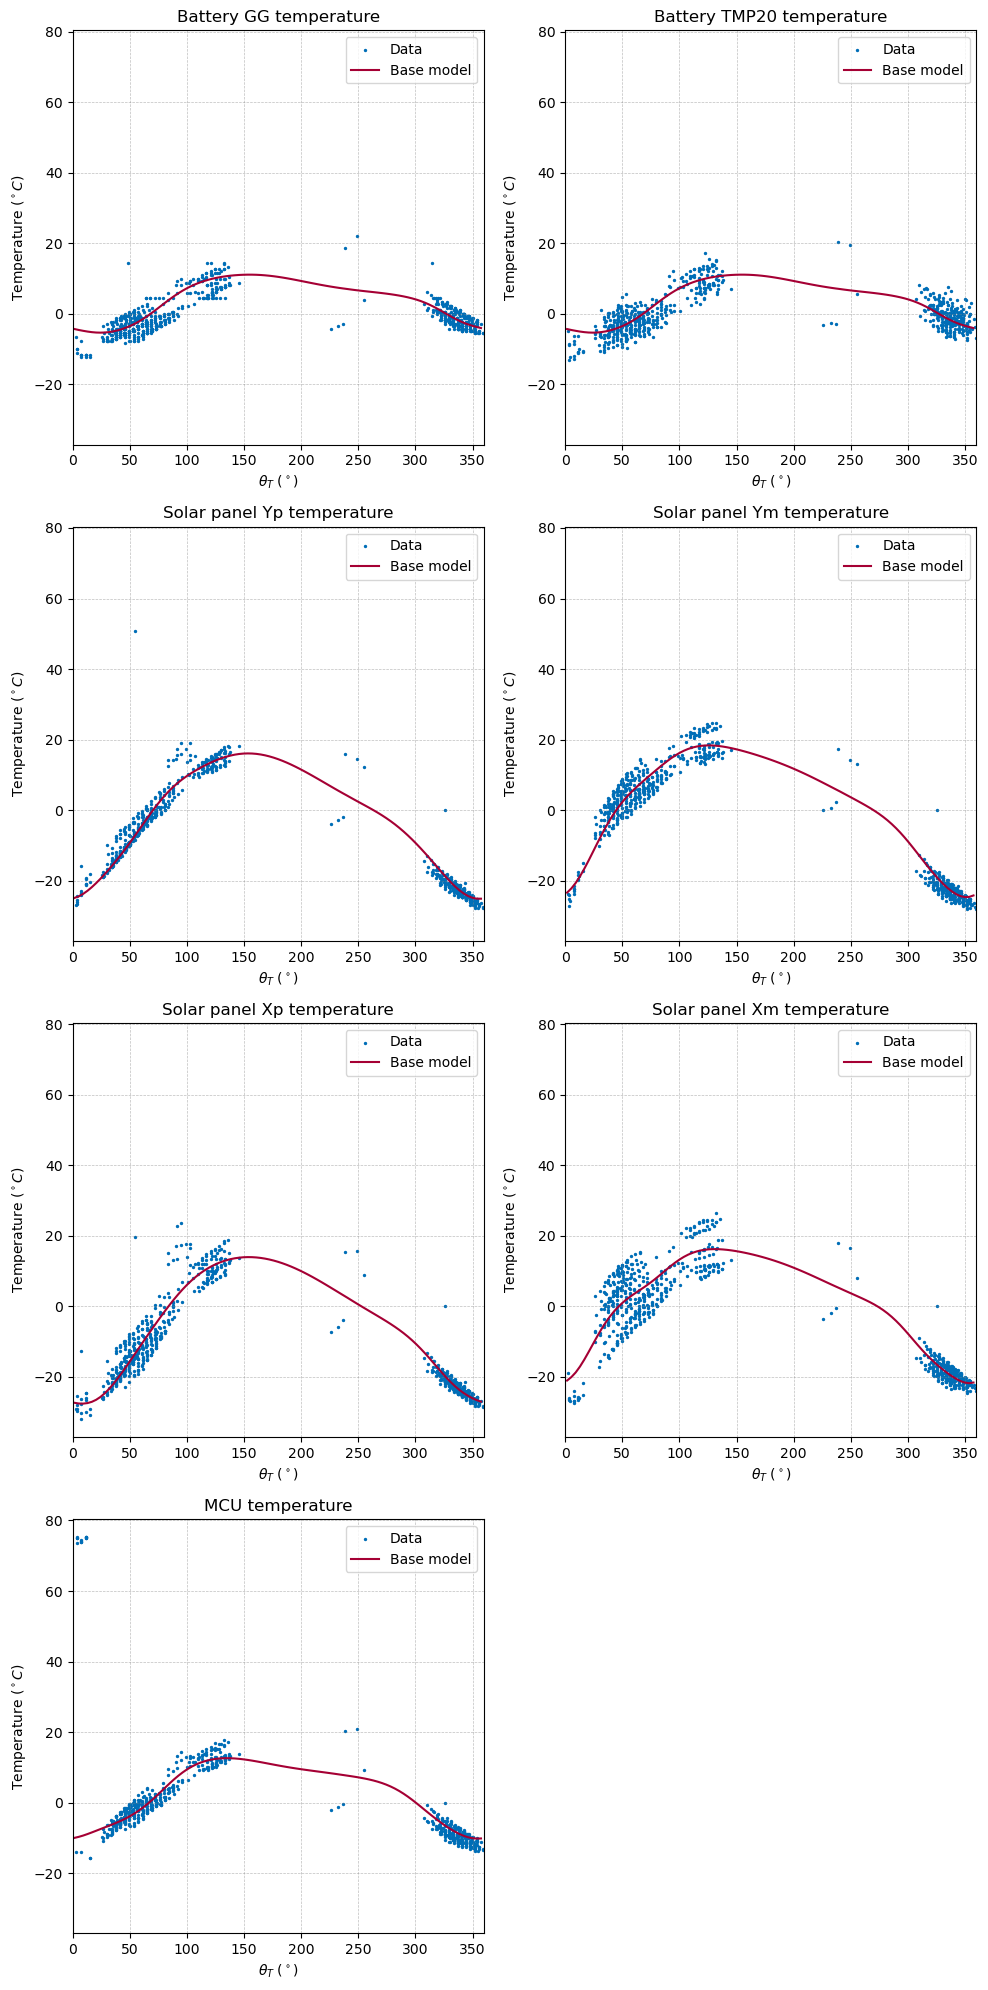

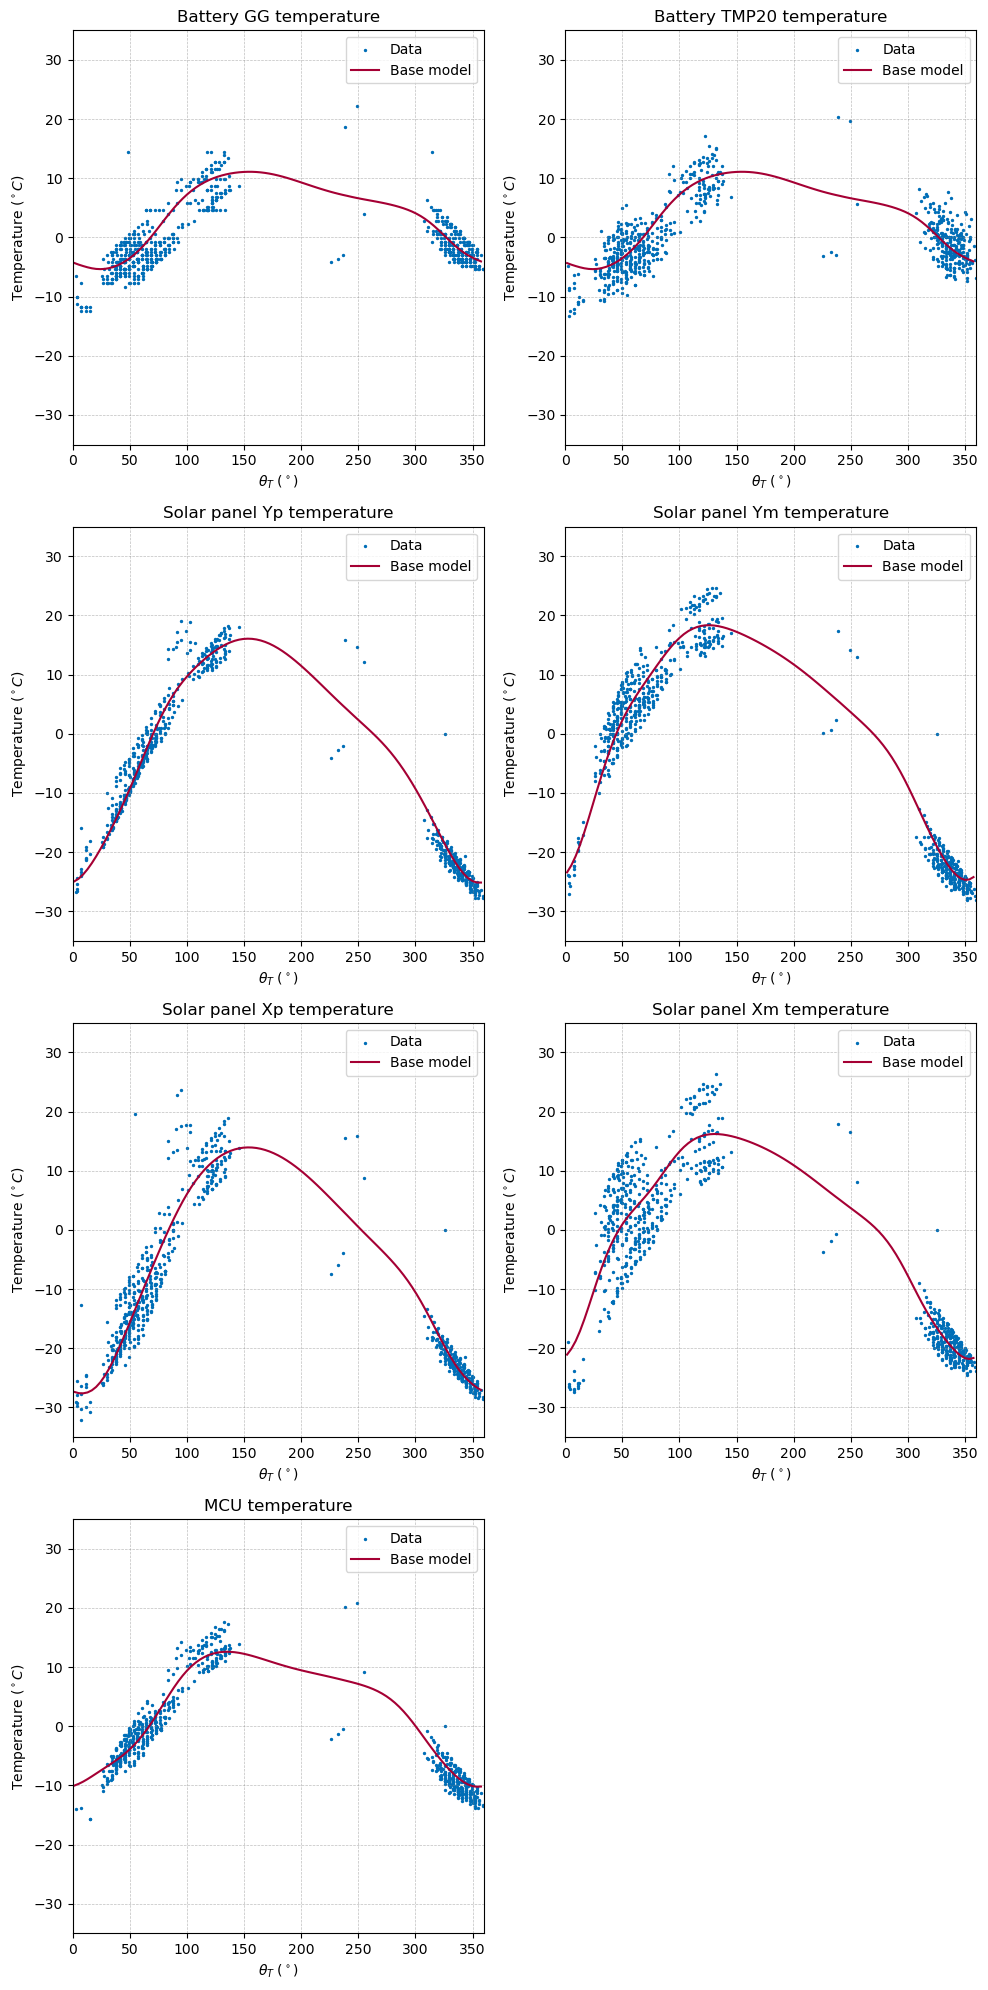

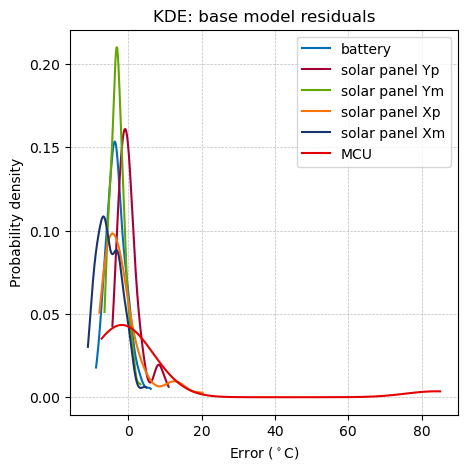

Battery:
Mean: -3.16 degC Std: 2.74 degC (area: 0.98)
Solar panel Yp:
Mean: 0.19 degC Std: 3.10 degC (area: 0.96)
Solar panel Ym:
Mean: -2.90 degC Std: 1.96 degC (area: 0.96)
Solar panel Xp:
Mean: -1.57 degC Std: 5.66 degC (area: 0.92)
Solar panel Xm:
Mean: -5.08 degC Std: 3.35 degC (area: 0.97)
MCU:
Mean: 4.67 degC Std: 22.45 degC (area: 0.73)


Probability of error within 1 degC:
Battery: 0.12
Solar panel Yp: 0.28
Solar panel Ym: 0.12
Solar panel Xp: 0.11
Solar panel Xm: 0.09
MCU: 0.08


In [71]:
theta_T_data = telem_df["theta_T (deg)"].to_numpy()
temp_data = telem_df[
    [
        "battery GG temperature (deg C)",
        "battery TMP20 temperature (deg C)",
        "solar panel Yp temperature (deg C)",
        "solar panel Ym temperature (deg C)",
        "solar panel Xp temperature (deg C)",
        "solar panel Xm temperature (deg C)",
        "MCU temperature (deg C)",
    ]
].to_numpy()

theta_T_model = artificial_df["theta_T"].to_numpy()
temp_model = artificial_df[
    [
        "battery temp",
        "solar panel Yp temp",
        "solar panel Ym temp",
        "solar panel Xp temp",
        "solar panel Xm temp",
        "MCU temp",
    ]
].to_numpy() * (max_temp - min_temp) + min_temp


plot_model(
    theta_T_data=theta_T_data,
    temp_data=temp_data,
    theta_T_model=theta_T_model,
    temp_model=temp_model,
)

plot_model(
    theta_T_data=theta_T_data,
    temp_data=temp_data,
    theta_T_model=theta_T_model,
    temp_model=temp_model,
    limit_axis=((0, 360), (-35, 35))
)

y_pred_base = model_base.predict(test_base_x, verbose=0)
residuals = (test_base_y - y_pred_base) * (max_temp - min_temp)

base_stats = kde(residuals, plt_title="KDE: base model residuals", return_stats=True)

In [69]:
model_base.save(r"./base-model-illum.h5")

In [72]:
# Checking contiguity of available temperature data:
contiguity_train_df = train_norm_df.copy()

# Pass: when subsequent datapoints are within 1 minute of each other
contiguity_train_df["Pass"] = np.nan

pass_no = 0
contiguity_train_df.loc[0, "Pass"] = pass_no

for i in range(1, len(contiguity_train_df)):
    if contiguity_train_df["time (jd)"][i] - contiguity_train_df["time (jd)"][i-1] > 1.1/1440:
        pass_no += 1
    contiguity_train_df.loc[i, "Pass"] = pass_no

pass_train_df = pd.DataFrame(columns=["pass", "count"], index=range(pass_no+1))
for i in range(pass_no+1):
    pass_train_df.loc[i, "pass"] = i
    pass_train_df.loc[i, "count"] = len(contiguity_train_df[contiguity_train_df["Pass"] == i])

count_df = pd.DataFrame(columns=["count", "train no", "test no"], index=range(1, max(pass_train_df["count"])+1))
for i in range(1, max(pass_train_df["count"])+1):
    count_df.loc[i, "count"] = i
    count_df.loc[i, "train no"] = len(pass_train_df[pass_train_df["count"] == i])

contiguity_test_df = test_norm_df.copy()
contiguity_test_df["Pass"] = np.nan
pass_no = 0
contiguity_test_df.loc[0, "Pass"] = pass_no

for i in range(1, len(contiguity_test_df)):
    if contiguity_test_df["time (jd)"][i] - contiguity_test_df["time (jd)"][i-1] > 1.1/1440:
        pass_no += 1
    contiguity_test_df.loc[i, "Pass"] = pass_no

pass_test_df = pd.DataFrame(columns=["pass", "count"], index=range(pass_no+1))
for i in range(pass_no+1):
    pass_test_df.loc[i, "pass"] = i
    pass_test_df.loc[i, "count"] = len(contiguity_test_df[contiguity_test_df["Pass"] == i])

for i in range(1, max(pass_test_df["count"])+1):
    count_df.loc[i, "test no"] = len(pass_test_df[pass_test_df["count"] == i])

print(count_df)

   count train no test no
1      1       96      42
2      2       40      21
3      3       22       6
4      4       23       7
5      5       12       0
6      6       10       2
7      7        8       1
8      8        3     NaN
9      9        4     NaN
10    10        2     NaN


In [73]:
def window_data_res(df, base_model_predictions, window_size):
    columns = np.concatenate((
        ["theta_T"],
        ["illumination"],
        ["input battery temp " + str(i) for i in range(window_size)],
        ["input solar panel Yp temp " + str(i) for i in range(window_size)],
        ["input solar panel Ym temp " + str(i) for i in range(window_size)],
        ["input solar panel Xp temp " + str(i) for i in range(window_size)],
        ["input solar panel Xm temp " + str(i) for i in range(window_size)],
        ["input MCU temp " + str(i) for i in range(window_size)],
        ["predicted battery temp"],
        ["predicted solar panel Yp temp"],
        ["predicted solar panel Ym temp"],
        ["predicted solar panel Xp temp"],
        ["predicted solar panel Xm temp"],
        ["predicted MCU temp"],
        ["output battery temp"],
        ["output solar panel Yp temp"],
        ["output solar panel Ym temp"],
        ["output solar panel Xp temp"],
        ["output solar panel Xm temp"],
        ["output MCU temp"]
    ))

    window_df = pd.DataFrame(columns=columns, index=range(len(df) - window_size))

    with alive_bar(len(window_df), theme="classic", force_tty=True) as bar:
        for i in range(len(window_df)):
            if df["time (jd)"][i + window_size] - df["time (jd)"][i] > window_size * 1.1 / 1440:
                bar()
                continue

            window_df.loc[i, "theta_T"] = np.float64(df.loc[i + window_size, "theta_T (deg)"])
            window_df.loc[i, "illumination"] = np.int64(1 if df.loc[i + window_size, "theta_T (deg)"] < 360 * (1 - df.loc[i + window_size, "fe"]) else 0)
            for j in range(window_size):
                window_df.loc[i, "input battery temp " + str(j)] = np.float64(df.loc[i + j, "battery TMP20 temperature (deg C)"])
                window_df.loc[i, "input solar panel Yp temp " + str(j)] = np.float64(df.loc[i + j, "solar panel Yp temperature (deg C)"])
                window_df.loc[i, "input solar panel Ym temp " + str(j)] = np.float64(df.loc[i + j, "solar panel Ym temperature (deg C)"])
                window_df.loc[i, "input solar panel Xp temp " + str(j)] = np.float64(df.loc[i + j, "solar panel Xp temperature (deg C)"])
                window_df.loc[i, "input solar panel Xm temp " + str(j)] = np.float64(df.loc[i + j, "solar panel Xm temperature (deg C)"])
                window_df.loc[i, "input MCU temp " + str(j)] = np.float64(df.loc[i + j, "MCU temperature (deg C)"])

            window_df.loc[i, "predicted battery temp"] = np.float64(base_model_predictions[i + window_size][0])
            window_df.loc[i, "predicted solar panel Yp temp"] = np.float64(base_model_predictions[i + window_size, 1])
            window_df.loc[i, "predicted solar panel Ym temp"] = np.float64(base_model_predictions[i + window_size, 2])
            window_df.loc[i, "predicted solar panel Xp temp"] = np.float64(base_model_predictions[i + window_size, 3])
            window_df.loc[i, "predicted solar panel Xm temp"] = np.float64(base_model_predictions[i + window_size, 4])
            window_df.loc[i, "predicted MCU temp"] = np.float64(base_model_predictions[i + window_size][5])

            window_df.loc[i, "output battery temp"] = np.float64(df.loc[i + window_size, "battery TMP20 temperature (deg C)"])
            window_df.loc[i, "output solar panel Yp temp"] = np.float64(df.loc[i + window_size, "solar panel Yp temperature (deg C)"])
            window_df.loc[i, "output solar panel Ym temp"] = np.float64(df.loc[i + window_size, "solar panel Ym temperature (deg C)"])
            window_df.loc[i, "output solar panel Xp temp"] = np.float64(df.loc[i + window_size, "solar panel Xp temperature (deg C)"])
            window_df.loc[i, "output solar panel Xm temp"] = np.float64(df.loc[i + window_size, "solar panel Xm temperature (deg C)"])
            window_df.loc[i, "output MCU temp"] = np.float64(df.loc[i + window_size, "MCU temperature (deg C)"])

            bar()
    return window_df


[========================================] 589/589 [100%] in 0.6s (1044.45/s)                                           
[========================================] 148/148 [100%] in 0.1s (955.73/s)                                            
Epoch 1/5000
12/12 [==============================] - 1s 31ms/step - loss: 7.8545e-04 - mean_absolute_error: 0.0208 - val_loss: 0.0052 - val_mean_absolute_error: 0.0417
Epoch 2/5000
12/12 [==============================] - 0s 10ms/step - loss: 6.9429e-04 - mean_absolute_error: 0.0195 - val_loss: 0.0052 - val_mean_absolute_error: 0.0416
Epoch 3/5000
12/12 [==============================] - 0s 10ms/step - loss: 6.5751e-04 - mean_absolute_error: 0.0187 - val_loss: 0.0051 - val_mean_absolute_error: 0.0406
Epoch 4/5000
12/12 [==============================] - 0s 10ms/step - loss: 6.3270e-04 - mean_absolute_error: 0.0182 - val_loss: 0.0051 - val_mean_absolute_error: 0.0400
Epoch 5/5000
12/12 [==============================] - 0s 10ms/step - loss: 6.0958e

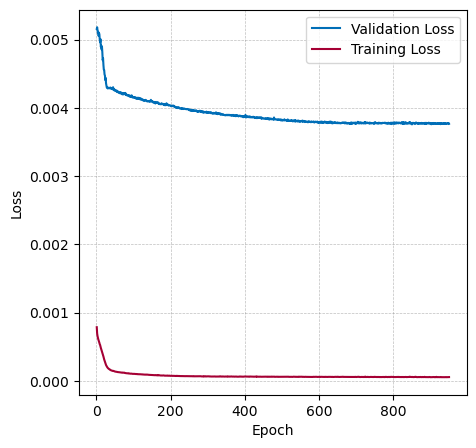

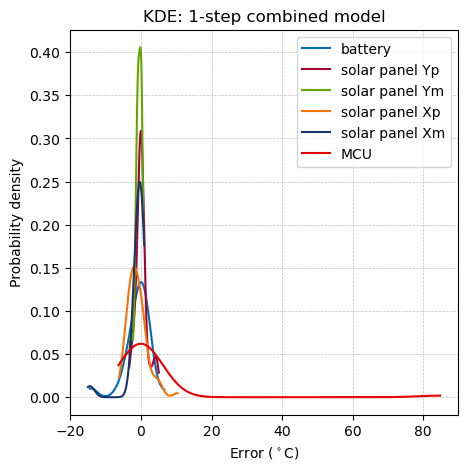

Battery:
Mean: -0.93 degC Std: 3.73 degC (area: 0.97)
Solar panel Yp:
Mean: 0.19 degC Std: 1.75 degC (area: 0.96)
Solar panel Ym:
Mean: -0.68 degC Std: 0.95 degC (area: 0.92)
Solar panel Xp:
Mean: -1.09 degC Std: 2.83 degC (area: 0.97)
Solar panel Xm:
Mean: -1.02 degC Std: 2.96 degC (area: 0.80)
MCU:
Mean: 2.33 degC Std: 14.20 degC (area: 0.83)


Probability of error within 1 degC:
Battery: 0.24
Solar panel Yp: 0.52
Solar panel Ym: 0.60
Solar panel Xp: 0.23
Solar panel Xm: 0.43
MCU: 0.11


In [74]:
# Creating a residual model with the previous temperature as input:
# Step size: 1 previous input
step_size = 1
base_model_predictions = model_base.predict(train_base_x, verbose=0)
train_res_1_df = window_data_res(train_norm_df, base_model_predictions, step_size).dropna(how='all').reset_index(drop=True)
train_res_1_x = np.empty(shape=(len(train_res_1_df), 1 + 6 * (step_size + 1)))
train_res_1_y = np.empty(shape=(len(train_res_1_df), 6))
for i in range(len(train_res_1_df)):
    train_res_1_x[i, 0] = train_res_1_df["illumination"][i]
    train_res_1_x[i, 1:(1 + 6 * step_size)] = train_res_1_df.iloc[i, 2:(2 + 6 * step_size)].values
    train_res_1_x[i, (1 + 6 * step_size):(7 + 6 * step_size)] = train_res_1_df.iloc[i, -12:-6].values

    train_res_1_y[i, 0:] = train_res_1_df.iloc[i, -6:].values - train_res_1_df.iloc[i, -12:-6].values

base_model_predictions = model_base.predict(test_base_x, verbose=0)
test_res_1_df = window_data_res(test_norm_df, base_model_predictions, step_size).dropna(how='all').reset_index(drop=True)
test_res_1_x = np.empty(shape=(len(test_res_1_df), 1 + 6 * (step_size + 1)))
test_res_1_y = np.empty(shape=(len(test_res_1_df), 6))
for i in range(len(test_res_1_df)):
    test_res_1_x[i, 0] = test_res_1_df["illumination"][i]
    test_res_1_x[i, 1:(1 + 6 * step_size)] = test_res_1_df.iloc[i, 2:(2 + 6 * step_size)].values
    test_res_1_x[i, (1 + 6 * step_size):(7 + 6 * step_size)] = test_res_1_df.iloc[i, -12:-6].values

    test_res_1_y[i, 0:] = test_res_1_df.iloc[i, -6:].values - test_res_1_df.iloc[i, -12:-6].values
    
# Create residual correction model
model_res_1 = tf.keras.Sequential()
model_res_1.add(tf.keras.layers.Dense(256, activation="relu", input_shape=(1 + 6 * (step_size + 1),)))
model_res_1.add(tf.keras.layers.Dense(256, activation="relu"))
model_res_1.add(tf.keras.layers.Dense(128, activation="relu"))
model_res_1.add(tf.keras.layers.Dense(128, activation="relu"))
model_res_1.add(tf.keras.layers.Dense(64, activation="relu"))
model_res_1.add(tf.keras.layers.Dense(32, activation="relu"))
model_res_1.add(tf.keras.layers.Dense(16, activation="relu"))
model_res_1.add(tf.keras.layers.Dense(6, activation="linear"))

model_res_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=4e-5),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=100,
    restore_best_weights=True
)

history_97_res = model_res_1.fit(
    train_res_1_x,
    train_res_1_y,
    epochs=5000,
    validation_data=(test_res_1_x, test_res_1_y),
    callbacks=[early_stopping],
)

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_97_res.history["loss"]), len(history_97_res.history["loss"])),
    history_97_res.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_97_res.history["loss"]), len(history_97_res.history["loss"])),
    history_97_res.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Checking the accuracy of the combined model:
y_base = test_res_1_df.iloc[:, -12:-6].to_numpy(dtype=np.float64)
y_res_model = model_res_1.predict(test_res_1_x, verbose=0)
y_combined = (y_base + y_res_model) * (max_temp - min_temp) + min_temp

y_actual = test_res_1_df.iloc[:, -6:].to_numpy(dtype=np.float64) * (max_temp - min_temp) + min_temp

y_res = y_actual - y_combined

res_1_stats = kde(y_res, plt_title="KDE: 1-step combined model", return_stats=True)

[========================================] 588/588 [100%] in 0.6s (981.47/s)                                            
[========================================] 147/147 [100%] in 0.1s (2091.22/s)                                           
Epoch 1/5000
8/8 [==============================] - 1s 58ms/step - loss: 8.4486e-04 - mean_absolute_error: 0.0209 - val_loss: 0.0018 - val_mean_absolute_error: 0.0339
Epoch 2/5000
8/8 [==============================] - 0s 10ms/step - loss: 7.4089e-04 - mean_absolute_error: 0.0194 - val_loss: 0.0018 - val_mean_absolute_error: 0.0340
Epoch 3/5000
8/8 [==============================] - 0s 10ms/step - loss: 6.8791e-04 - mean_absolute_error: 0.0190 - val_loss: 0.0018 - val_mean_absolute_error: 0.0338
Epoch 4/5000
8/8 [==============================] - 0s 10ms/step - loss: 6.6369e-04 - mean_absolute_error: 0.0188 - val_loss: 0.0017 - val_mean_absolute_error: 0.0337
Epoch 5/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.4253e-04 - mean_

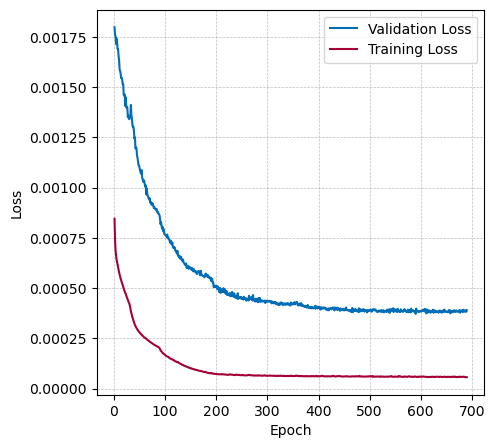

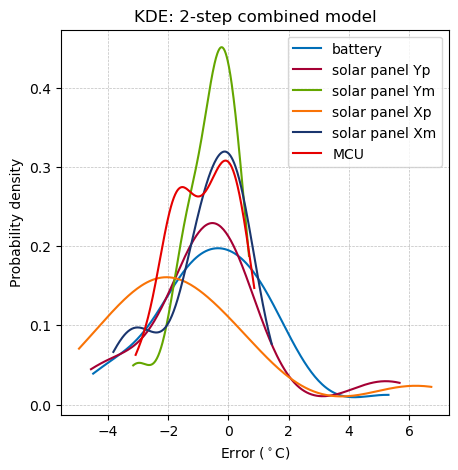

Battery:
Mean: -0.49 degC Std: 1.93 degC (area: 0.95)
Solar panel Yp:
Mean: -0.54 degC Std: 2.24 degC (area: 0.92)
Solar panel Ym:
Mean: -0.64 degC Std: 0.90 degC (area: 0.91)
Solar panel Xp:
Mean: -1.26 degC Std: 2.82 degC (area: 0.89)
Solar panel Xm:
Mean: -0.78 degC Std: 1.33 degC (area: 0.93)
MCU:
Mean: -0.85 degC Std: 1.04 degC (area: 0.91)


Probability of error within 1 degC:
Battery: 0.37
Solar panel Yp: 0.39
Solar panel Ym: 0.62
Solar panel Xp: 0.21
Solar panel Xm: 0.55
MCU: 0.49


In [75]:
# Creating a residual model with the previous temperature as input:
# Step size: 1 previous input
step_size = 2
base_model_predictions = model_base.predict(train_base_x, verbose=0)
train_res_2_df = window_data_res(train_norm_df, base_model_predictions, step_size).dropna(how='all').reset_index(drop=True)
train_res_2_x = np.empty(shape=(len(train_res_2_df), 1 + 6 * (step_size + 1)))
train_res_2_y = np.empty(shape=(len(train_res_2_df), 6))
for i in range(len(train_res_2_df)):
    train_res_2_x[i, 0] = train_res_2_df["illumination"][i]
    train_res_2_x[i, 1:(1 + 6 * step_size)] = train_res_2_df.iloc[i, 2:(2 + 6 * step_size)].values
    train_res_2_x[i, (1 + 6 * step_size):(7 + 6 * step_size)] = train_res_2_df.iloc[i, -12:-6].values

    train_res_2_y[i, 0:] = train_res_2_df.iloc[i, -6:].values - train_res_2_df.iloc[i, -12:-6].values

base_model_predictions = model_base.predict(test_base_x, verbose=0)
test_res_2_df = window_data_res(test_norm_df, base_model_predictions, step_size).dropna(how='all').reset_index(drop=True)
test_res_2_x = np.empty(shape=(len(test_res_2_df), 1 + 6 * (step_size + 1)))
test_res_2_y = np.empty(shape=(len(test_res_2_df), 6))
for i in range(len(test_res_2_df)):
    test_res_2_x[i, 0] = test_res_2_df["illumination"][i]
    test_res_2_x[i, 1:(1 + 6 * step_size)] = test_res_2_df.iloc[i, 2:(2 + 6 * step_size)].values
    test_res_2_x[i, (1 + 6 * step_size):(7 + 6 * step_size)] = test_res_2_df.iloc[i, -12:-6].values

    test_res_2_y[i, 0:] = test_res_2_df.iloc[i, -6:].values - test_res_2_df.iloc[i, -12:-6].values

# Create residual correction model
model_res_2 = tf.keras.Sequential()
model_res_2.add(tf.keras.layers.Dense(256, activation="relu", input_shape=(1 + 6 * (step_size + 1),)))
model_res_2.add(tf.keras.layers.Dense(256, activation="relu"))
model_res_2.add(tf.keras.layers.Dense(128, activation="relu"))
model_res_2.add(tf.keras.layers.Dense(128, activation="relu"))
model_res_2.add(tf.keras.layers.Dense(64, activation="relu"))
model_res_2.add(tf.keras.layers.Dense(32, activation="relu"))
model_res_2.add(tf.keras.layers.Dense(16, activation="relu"))
model_res_2.add(tf.keras.layers.Dense(6, activation="linear"))

model_res_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=4e-5),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=100,
    restore_best_weights=True
)

history_97_res = model_res_2.fit(
    train_res_2_x,
    train_res_2_y,
    epochs=5000,
    validation_data=(test_res_2_x, test_res_2_y),
    callbacks=[early_stopping],
)

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_97_res.history["loss"]), len(history_97_res.history["loss"])),
    history_97_res.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_97_res.history["loss"]), len(history_97_res.history["loss"])),
    history_97_res.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Checking the accuracy of the combined model:
y_base = test_res_2_df.iloc[:, -12:-6].to_numpy(dtype=np.float64)
y_res_model = model_res_2.predict(test_res_2_x, verbose=0)
y_combined = (y_base + y_res_model) * (max_temp - min_temp) + min_temp

y_actual = test_res_2_df.iloc[:, -6:].to_numpy(dtype=np.float64) * (max_temp - min_temp) + min_temp

y_res = y_actual - y_combined

res_2_stats = kde(y_res, plt_title="KDE: 2-step combined model", return_stats=True)

[========================================] 587/587 [100%] in 0.8s (1410.28/s)                                           
[========================================] 146/146 [100%] in 0.1s (513.31/s) 
Epoch 1/5000
6/6 [==============================] - 1s 72ms/step - loss: 8.6088e-04 - mean_absolute_error: 0.0214 - val_loss: 0.0013 - val_mean_absolute_error: 0.0285
Epoch 2/5000
6/6 [==============================] - 0s 15ms/step - loss: 7.4655e-04 - mean_absolute_error: 0.0199 - val_loss: 0.0013 - val_mean_absolute_error: 0.0298
Epoch 3/5000
6/6 [==============================] - 0s 16ms/step - loss: 6.8535e-04 - mean_absolute_error: 0.0191 - val_loss: 0.0014 - val_mean_absolute_error: 0.0313
Epoch 4/5000
6/6 [==============================] - 0s 14ms/step - loss: 6.5740e-04 - mean_absolute_error: 0.0188 - val_loss: 0.0014 - val_mean_absolute_error: 0.0319
Epoch 5/5000
6/6 [==============================] - 0s 15ms/step - loss: 6.4667e-04 - mean_absolute_error: 0.0186 - val_loss: 0.0015 

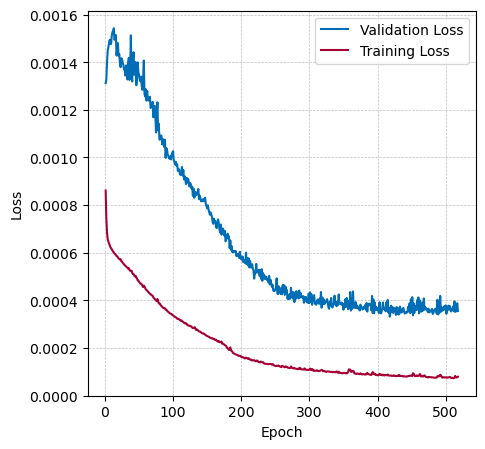

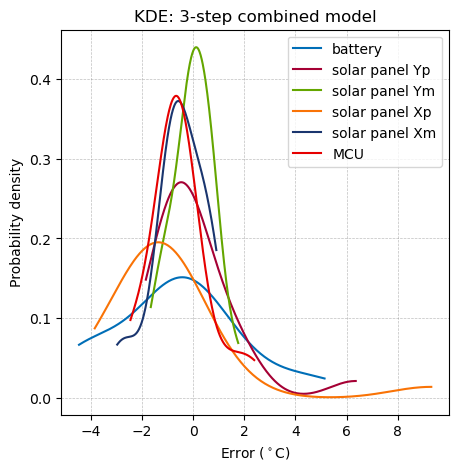

Battery:
Mean: -0.64 degC Std: 2.52 degC (area: 0.87)
Solar panel Yp:
Mean: 0.15 degC Std: 1.79 degC (area: 0.86)
Solar panel Ym:
Mean: -0.01 degC Std: 0.82 degC (area: 0.92)
Solar panel Xp:
Mean: -0.84 degC Std: 2.72 degC (area: 0.87)
Solar panel Xm:
Mean: -0.56 degC Std: 1.01 degC (area: 0.87)
MCU:
Mean: -0.54 degC Std: 1.13 degC (area: 0.91)


Probability of error within 1 degC:
Battery: 0.28
Solar panel Yp: 0.47
Solar panel Ym: 0.70
Solar panel Xp: 0.29
Solar panel Xm: 0.59
MCU: 0.52


In [76]:
# Creating a residual model with the previous temperature as input:
# Step size: 1 previous input
step_size = 3
base_model_predictions = model_base.predict(train_base_x, verbose=0)
train_res_3_df = window_data_res(train_norm_df, base_model_predictions, step_size).dropna(how='all').reset_index(drop=True)
train_res_3_x = np.empty(shape=(len(train_res_3_df), 1 + 6 * (step_size + 1)))
train_res_3_y = np.empty(shape=(len(train_res_3_df), 6))
for i in range(len(train_res_3_df)):
    train_res_3_x[i, 0] = train_res_3_df["illumination"][i]
    train_res_3_x[i, 1:(1 + 6 * step_size)] = train_res_3_df.iloc[i, 2:(2 + 6 * step_size)].values
    train_res_3_x[i, (1 + 6 * step_size):(7 + 6 * step_size)] = train_res_3_df.iloc[i, -12:-6].values

    train_res_3_y[i, 0:] = train_res_3_df.iloc[i, -6:].values - train_res_3_df.iloc[i, -12:-6].values

base_model_predictions = model_base.predict(test_base_x, verbose=0)
test_res_3_df = window_data_res(test_norm_df, base_model_predictions, step_size).dropna(how='all').reset_index(drop=True)
test_res_3_x = np.empty(shape=(len(test_res_3_df), 1 + 6 * (step_size + 1)))
test_res_3_y = np.empty(shape=(len(test_res_3_df), 6))
for i in range(len(test_res_3_df)):
    test_res_3_x[i, 0] = test_res_3_df["illumination"][i]
    test_res_3_x[i, 1:(1 + 6 * step_size)] = test_res_3_df.iloc[i, 2:(2 + 6 * step_size)].values
    test_res_3_x[i, (1 + 6 * step_size):(7 + 6 * step_size)] = test_res_3_df.iloc[i, -12:-6].values

    test_res_3_y[i, 0:] = test_res_3_df.iloc[i, -6:].values - test_res_3_df.iloc[i, -12:-6].values

# Create residual correction model
model_res_3 = tf.keras.Sequential()
model_res_3.add(tf.keras.layers.Dense(256, activation="relu", input_shape=(1 + 6 * (step_size + 1),)))
model_res_3.add(tf.keras.layers.Dense(256, activation="relu"))
model_res_3.add(tf.keras.layers.Dense(128, activation="relu"))
model_res_3.add(tf.keras.layers.Dense(128, activation="relu"))
model_res_3.add(tf.keras.layers.Dense(64, activation="relu"))
model_res_3.add(tf.keras.layers.Dense(32, activation="relu"))
model_res_3.add(tf.keras.layers.Dense(16, activation="relu"))
model_res_3.add(tf.keras.layers.Dense(6, activation="linear"))

model_res_3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=4e-5),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=100,
    restore_best_weights=True
)

history_97_res = model_res_3.fit(
    train_res_3_x,
    train_res_3_y,
    epochs=5000,
    validation_data=(test_res_3_x, test_res_3_y),
    callbacks=[early_stopping],
)

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_97_res.history["loss"]), len(history_97_res.history["loss"])),
    history_97_res.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_97_res.history["loss"]), len(history_97_res.history["loss"])),
    history_97_res.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Checking the accuracy of the combined model:
y_base = test_res_3_df.iloc[:, -12:-6].to_numpy(dtype=np.float64)
y_res_model = model_res_3.predict(test_res_3_x, verbose=0)
y_combined = (y_base + y_res_model) * (max_temp - min_temp) + min_temp

y_actual = test_res_3_df.iloc[:, -6:].to_numpy(dtype=np.float64) * (max_temp - min_temp) + min_temp

y_res = y_actual - y_combined

res_3_stats = kde(y_res, plt_title="KDE: 3-step combined model", return_stats=True)

[========================================] 586/586 [100%] in 0.4s (1533.69/s)                                           
[========================================] 145/145 [100%] in 0.1s (7430.71/s)                                           
Epoch 1/5000
4/4 [==============================] - 1s 88ms/step - loss: 0.0010 - mean_absolute_error: 0.0239 - val_loss: 0.0015 - val_mean_absolute_error: 0.0310
Epoch 2/5000
4/4 [==============================] - 0s 20ms/step - loss: 7.9755e-04 - mean_absolute_error: 0.0204 - val_loss: 0.0013 - val_mean_absolute_error: 0.0291
Epoch 3/5000
4/4 [==============================] - 0s 20ms/step - loss: 6.9270e-04 - mean_absolute_error: 0.0185 - val_loss: 0.0011 - val_mean_absolute_error: 0.0279
Epoch 4/5000
4/4 [==============================] - 0s 19ms/step - loss: 6.4728e-04 - mean_absolute_error: 0.0178 - val_loss: 0.0011 - val_mean_absolute_error: 0.0271
Epoch 5/5000
4/4 [==============================] - 0s 17ms/step - loss: 6.2570e-04 - mean_abs

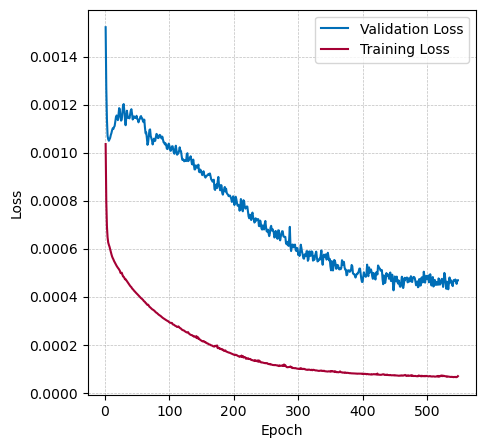

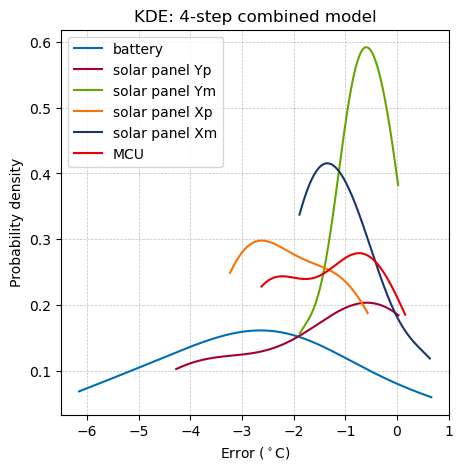

Battery:
Mean: -2.82 degC Std: 2.01 degC (area: 0.82)
Solar panel Yp:
Mean: -1.68 degC Std: 1.62 degC (area: 0.66)
Solar panel Ym:
Mean: -0.72 degC Std: 0.58 degC (area: 0.78)
Solar panel Xp:
Mean: -2.03 degC Std: 0.96 degC (area: 0.70)
Solar panel Xm:
Mean: -1.00 degC Std: 0.82 degC (area: 0.73)
MCU:
Mean: -1.36 degC Std: 1.02 degC (area: 0.69)


Probability of error within 1 degC:
Battery: 0.14
Solar panel Yp: 0.20
Solar panel Ym: 0.54
Solar panel Xp: 0.09
Solar panel Xm: 0.38
MCU: 0.29


In [77]:
# Creating a residual model with the previous temperature as input:
# Step size: 1 previous input
step_size = 4
base_model_predictions = model_base.predict(train_base_x, verbose=0)
train_res_4_df = window_data_res(train_norm_df, base_model_predictions, step_size).dropna(how='all').reset_index(drop=True)
train_res_4_x = np.empty(shape=(len(train_res_4_df), 1 + 6 * (step_size + 1)))
train_res_4_y = np.empty(shape=(len(train_res_4_df), 6))
for i in range(len(train_res_4_df)):
    train_res_4_x[i, 0] = train_res_4_df["illumination"][i]
    train_res_4_x[i, 1:(1 + 6 * step_size)] = train_res_4_df.iloc[i, 2:(2 + 6 * step_size)].values
    train_res_4_x[i, (1 + 6 * step_size):(7 + 6 * step_size)] = train_res_4_df.iloc[i, -12:-6].values

    train_res_4_y[i, 0:] = train_res_4_df.iloc[i, -6:].values - train_res_4_df.iloc[i, -12:-6].values

base_model_predictions = model_base.predict(test_base_x, verbose=0)
test_res_4_df = window_data_res(test_norm_df, base_model_predictions, step_size).dropna(how='all').reset_index(drop=True)
test_res_4_x = np.empty(shape=(len(test_res_4_df), 1 + 6 * (step_size + 1)))
test_res_4_y = np.empty(shape=(len(test_res_4_df), 6))
for i in range(len(test_res_4_df)):
    test_res_4_x[i, 0] = test_res_4_df["illumination"][i]
    test_res_4_x[i, 1:(1 + 6 * step_size)] = test_res_4_df.iloc[i, 2:(2 + 6 * step_size)].values
    test_res_4_x[i, (1 + 6 * step_size):(7 + 6 * step_size)] = test_res_4_df.iloc[i, -12:-6].values

    test_res_4_y[i, 0:] = test_res_4_df.iloc[i, -6:].values - test_res_4_df.iloc[i, -12:-6].values

# Create residual correction model
model_res_4 = tf.keras.Sequential()
model_res_4.add(tf.keras.layers.Dense(256, activation="relu", input_shape=(1 + 6 * (step_size + 1),)))
model_res_4.add(tf.keras.layers.Dense(256, activation="relu"))
model_res_4.add(tf.keras.layers.Dense(128, activation="relu"))
model_res_4.add(tf.keras.layers.Dense(128, activation="relu"))
model_res_4.add(tf.keras.layers.Dense(64, activation="relu"))
model_res_4.add(tf.keras.layers.Dense(32, activation="relu"))
model_res_4.add(tf.keras.layers.Dense(16, activation="relu"))
model_res_4.add(tf.keras.layers.Dense(6, activation="linear"))

model_res_4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=4e-5),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=100,
    restore_best_weights=True
)

history_97_res = model_res_4.fit(
    train_res_4_x,
    train_res_4_y,
    epochs=5000,
    validation_data=(test_res_4_x, test_res_4_y),
    callbacks=[early_stopping],
)

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_97_res.history["loss"]), len(history_97_res.history["loss"])),
    history_97_res.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_97_res.history["loss"]), len(history_97_res.history["loss"])),
    history_97_res.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Checking the accuracy of the combined model:
y_base = test_res_4_df.iloc[:, -12:-6].to_numpy(dtype=np.float64)
y_res_model = model_res_4.predict(test_res_4_x, verbose=0)
y_combined = (y_base + y_res_model) * (max_temp - min_temp) + min_temp

y_actual = test_res_4_df.iloc[:, -6:].to_numpy(dtype=np.float64) * (max_temp - min_temp) + min_temp

y_res = y_actual - y_combined

res_4_stats = kde(y_res, plt_title="KDE: 4-step combined model", return_stats=True)

[========================================] 585/585 [100%] in 0.3s (2724.40/s)                                           
[========================================] 144/144 [100%] in 0.1s (1103.98/s) 
Epoch 1/5000
2/2 [==============================] - 1s 251ms/step - loss: 0.0013 - mean_absolute_error: 0.0270 - val_loss: 0.0030 - val_mean_absolute_error: 0.0430
Epoch 2/5000
2/2 [==============================] - 0s 32ms/step - loss: 0.0010 - mean_absolute_error: 0.0239 - val_loss: 0.0029 - val_mean_absolute_error: 0.0413
Epoch 3/5000
2/2 [==============================] - 0s 52ms/step - loss: 8.6913e-04 - mean_absolute_error: 0.0219 - val_loss: 0.0029 - val_mean_absolute_error: 0.0403
Epoch 4/5000
2/2 [==============================] - 0s 47ms/step - loss: 7.7870e-04 - mean_absolute_error: 0.0205 - val_loss: 0.0028 - val_mean_absolute_error: 0.0400
Epoch 5/5000
2/2 [==============================] - 0s 63ms/step - loss: 7.0887e-04 - mean_absolute_error: 0.0194 - val_loss: 0.0027 - val_

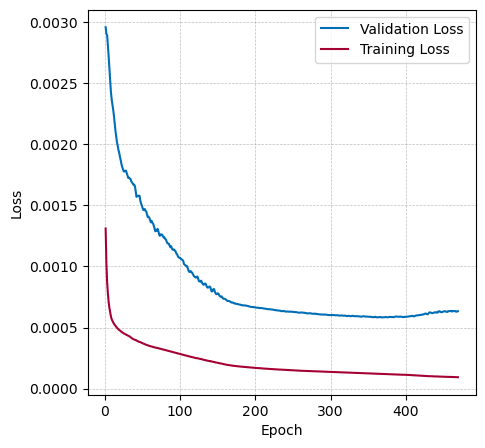

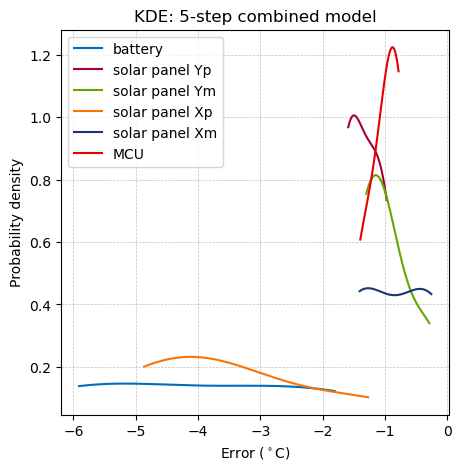

Battery:
Mean: -4.02 degC Std: 1.75 degC (area: 0.57)
Solar panel Yp:
Mean: -1.33 degC Std: 0.27 degC (area: 0.57)
Solar panel Ym:
Mean: -0.94 degC Std: 0.40 degC (area: 0.60)
Solar panel Xp:
Mean: -3.46 degC Std: 1.35 degC (area: 0.64)
Solar panel Xm:
Mean: -0.85 degC Std: 0.55 degC (area: 0.51)
MCU:
Mean: -1.01 degC Std: 0.25 degC (area: 0.59)


Probability of error within 1 degC:
Battery: 0.00
Solar panel Yp: 0.02
Solar panel Ym: 0.36
Solar panel Xp: 0.00
Solar panel Xm: 0.32
MCU: 0.26


In [78]:
# Creating a residual model with the previous temperature as input:
# Step size: 1 previous input
step_size = 5
base_model_predictions = model_base.predict(train_base_x, verbose=0)
train_res_5_df = window_data_res(train_norm_df, base_model_predictions, step_size).dropna(how='all').reset_index(drop=True)
train_res_5_x = np.empty(shape=(len(train_res_5_df), 1 + 6 * (step_size + 1)))
train_res_5_y = np.empty(shape=(len(train_res_5_df), 6))
for i in range(len(train_res_5_df)):
    train_res_5_x[i, 0] = train_res_5_df["illumination"][i]
    train_res_5_x[i, 1:(1 + 6 * step_size)] = train_res_5_df.iloc[i, 2:(2 + 6 * step_size)].values
    train_res_5_x[i, (1 + 6 * step_size):(7 + 6 * step_size)] = train_res_5_df.iloc[i, -12:-6].values

    train_res_5_y[i, 0:] = train_res_5_df.iloc[i, -6:].values - train_res_5_df.iloc[i, -12:-6].values

base_model_predictions = model_base.predict(test_base_x, verbose=0)
test_res_5_df = window_data_res(test_norm_df, base_model_predictions, step_size).dropna(how='all').reset_index(drop=True)
test_res_5_x = np.empty(shape=(len(test_res_5_df), 1 + 6 * (step_size + 1)))
test_res_5_y = np.empty(shape=(len(test_res_5_df), 6))
for i in range(len(test_res_5_df)):
    test_res_5_x[i, 0] = test_res_5_df["illumination"][i]
    test_res_5_x[i, 1:(1 + 6 * step_size)] = test_res_5_df.iloc[i, 2:(2 + 6 * step_size)].values
    test_res_5_x[i, (1 + 6 * step_size):(7 + 6 * step_size)] = test_res_5_df.iloc[i, -12:-6].values

    test_res_5_y[i, 0:] = test_res_5_df.iloc[i, -6:].values - test_res_5_df.iloc[i, -12:-6].values

# Create residual correction model
model_res_5 = tf.keras.Sequential()
model_res_5.add(tf.keras.layers.Dense(256, activation="relu", input_shape=(1 + 6 * (step_size + 1),)))
model_res_5.add(tf.keras.layers.Dense(256, activation="relu"))
model_res_5.add(tf.keras.layers.Dense(128, activation="relu"))
model_res_5.add(tf.keras.layers.Dense(128, activation="relu"))
model_res_5.add(tf.keras.layers.Dense(64, activation="relu"))
model_res_5.add(tf.keras.layers.Dense(32, activation="relu"))
model_res_5.add(tf.keras.layers.Dense(16, activation="relu"))
model_res_5.add(tf.keras.layers.Dense(6, activation="linear"))

model_res_5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=4e-5),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=100,
    restore_best_weights=True
)

history_97_res = model_res_5.fit(
    train_res_5_x,
    train_res_5_y,
    epochs=5000,
    validation_data=(test_res_5_x, test_res_5_y),
    callbacks=[early_stopping],
)

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_97_res.history["loss"]), len(history_97_res.history["loss"])),
    history_97_res.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_97_res.history["loss"]), len(history_97_res.history["loss"])),
    history_97_res.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Checking the accuracy of the combined model:
y_base = test_res_5_df.iloc[:, -12:-6].to_numpy(dtype=np.float64)
y_res_model = model_res_5.predict(test_res_5_x, verbose=0)
y_combined = (y_base + y_res_model) * (max_temp - min_temp) + min_temp

y_actual = test_res_5_df.iloc[:, -6:].to_numpy(dtype=np.float64) * (max_temp - min_temp) + min_temp

y_res = y_actual - y_combined

res_5_stats = kde(y_res, plt_title="KDE: 5-step combined model", return_stats=True)

In [79]:
# Tabulating the stats of base and residual models:
unprocessed_stats_df = pd.DataFrame(
    columns=[
        "Model",
        "Battery error mean (deg C)",
        "Battery error std (deg C)",
        "Battery 1 deg C error %",
        "Yp panel error mean (deg C)",
        "Yp panel error std (deg C)",
        "Yp panel 1 deg C error %",
        "Ym panel error mean (deg C)",
        "Ym panel error std (deg C)",
        "Ym panel 1 deg C error %",
        "Xp panel error mean (deg C)",
        "Xp panel error std (deg C)",
        "Xp panel 1 deg C error %",
        "Xm panel error mean (deg C)",
        "Xm panel error std (deg C)",
        "Xm panel 1 deg C error %",
        "MCU error mean (deg C)",
        "MCU error std (deg C)",
        "MCU 1 deg C error %",
    ]
)

unprocessed_stats_df.loc[0, "Model"] = "Base model"
point = 1
for i in range(6):
    for j in range(3):
        unprocessed_stats_df.iloc[0, point] = base_stats[0][j][i]
        point += 1

unprocessed_stats_df.loc[1, "Model"] = "1-step model"
point = 1
for i in range(6):
    for j in range(3):
        unprocessed_stats_df.iloc[1, point] = res_1_stats[0][j][i]
        point += 1

unprocessed_stats_df.loc[2, "Model"] = "2-step model"
point = 1
for i in range(6):
    for j in range(3):
        unprocessed_stats_df.iloc[2, point] = res_2_stats[0][j][i]
        point += 1

unprocessed_stats_df.loc[3, "Model"] = "3-step model"
point = 1
for i in range(6):
    for j in range(3):
        unprocessed_stats_df.iloc[3, point] = res_3_stats[0][j][i]
        point += 1

unprocessed_stats_df.loc[4, "Model"] = "4-step model"
point = 1
for i in range(6):
    for j in range(3):
        unprocessed_stats_df.iloc[4, point] = res_4_stats[0][j][i]
        point += 1

unprocessed_stats_df.loc[5, "Model"] = "5-step model"
point = 1
for i in range(6):
    for j in range(3):
        unprocessed_stats_df.iloc[5, point] = res_5_stats[0][j][i]
        point += 1

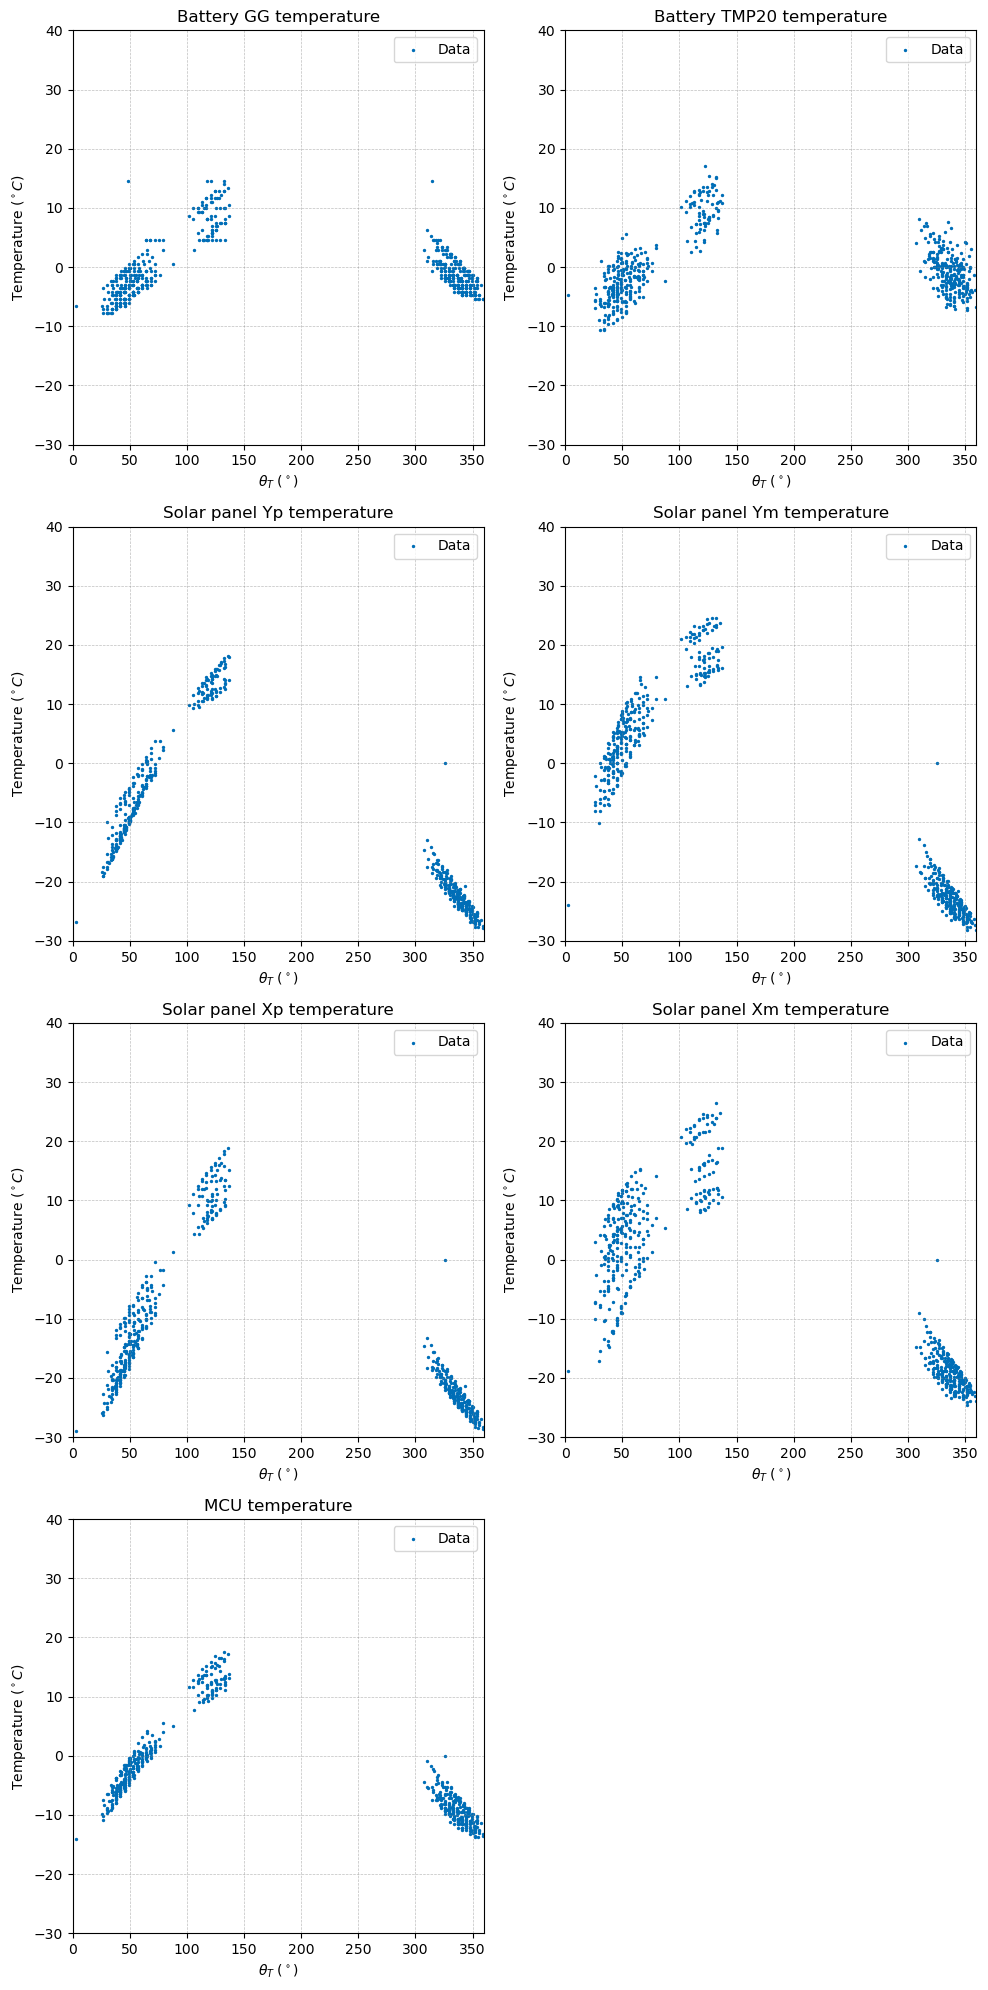

In [80]:
# Manually cleaning up the data:
train_cleaned_df = train_norm_df.copy()
for i, row in train_cleaned_df.iterrows():
    if 200 < row.loc["theta_T (deg)"] < 300:
        train_cleaned_df.iloc[i, :] = np.nan
        continue
    for temp in row.iloc[6:]:
        if temp > 0.66:
            train_cleaned_df.iloc[i, :] = np.nan
            break

test_cleaned_df = test_norm_df.copy()
for i, row in test_cleaned_df.iterrows():
    if 200 < row.loc["theta_T (deg)"] < 300:
        test_cleaned_df.iloc[i, :] = np.nan
        continue
    for temp in row.iloc[6:]:
        if temp > 0.66:
            test_cleaned_df.iloc[i, :] = np.nan
            break

train_cleaned_df = train_cleaned_df.dropna(how="all").reset_index(drop=True)
test_cleaned_df = test_cleaned_df.dropna(how="all").reset_index(drop=True)

plot_model(
    theta_T_data=train_cleaned_df["theta_T (deg)"].to_numpy(dtype=np.float64),
    temp_data=(train_cleaned_df.iloc[:, 6:].to_numpy(dtype=np.float64) * (max_temp - min_temp) + min_temp),
    limit_axis=((0, 360), (-30, 40))
)

In [81]:
# train_cleaned_base_df = window_data_base(train_cleaned_df, 96, delfi_pq)
# test_cleaned_base_df = window_data_base(test_cleaned_df, 96, delfi_pq)

# # Saving cleaned up test and train data:
# DF_SAVE_PATH = r"./base-cleaned.h5"
# train_cleaned_base_df.to_hdf(DF_SAVE_PATH, key="train", mode="w")
# test_cleaned_base_df.to_hdf(DF_SAVE_PATH, key="test", mode="a")

In [82]:
# Loading cleaned up test and train data:
DF_SAVE_PATH = r"./base-cleaned.h5"
train_cleaned_base_df = pd.read_hdf(DF_SAVE_PATH, key="train")
test_cleaned_base_df = pd.read_hdf(DF_SAVE_PATH, key="test")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, None, 256)         264192    
                                                                 
 lstm_8 (LSTM)               (None, None, 256)         525312    
                                                                 
 lstm_9 (LSTM)               (None, None, 128)         197120    
                                                                 
 lstm_10 (LSTM)              (None, None, 128)         131584    
                                                                 
 lstm_11 (LSTM)              (None, None, 64)          49408     
                                                                 
 lstm_12 (LSTM)              (None, None, 32)          12416     
                                                                 
 lstm_13 (LSTM)              (None, 16)               

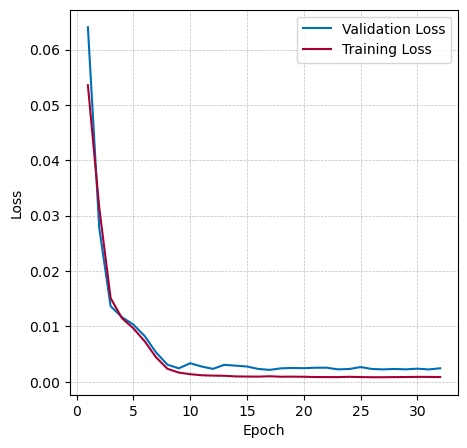

In [83]:
model_cleaned_base_layers = np.empty(shape=(7), dtype=dict,)
model_cleaned_base_layers[0] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
model_cleaned_base_layers[1] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
model_cleaned_base_layers[2] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
model_cleaned_base_layers[3] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
model_cleaned_base_layers[4] = {
    "type": "LSTM",
    "units": 64,
    "activation": "tanh",
}
model_cleaned_base_layers[5] = {
    "type": "LSTM",
    "units": 32,
    "activation": "tanh",
}
model_cleaned_base_layers[6] = {
    "type": "LSTM",
    "units": 16,
    "activation": "tanh",
}

# Creating the training and testing numpy arrays:
train_cleaned_base_x = np.empty(shape=(len(train_cleaned_base_df), 96, 1), dtype=np.int64)
train_cleaned_base_y = np.empty(shape=(len(train_cleaned_base_df), 6), dtype=np.float64)

for i, row in train_cleaned_base_df.iterrows():
    train_cleaned_base_x[i, :, 0] = row.iloc[1:97].values
    train_cleaned_base_y[i, :] = row.iloc[97:].values

test_cleaned_base_x = np.empty(shape=(len(test_cleaned_base_df), 96, 1), dtype=np.int64)
test_cleaned_base_y = np.empty(shape=(len(test_cleaned_base_df), 6), dtype=np.float64)

for i, row in test_cleaned_base_df.iterrows():
    test_cleaned_base_x[i, :, 0] = row.iloc[1:97].values
    test_cleaned_base_y[i, :] = row.iloc[97:].values

model_cleaned_base, recommended_device = create_model(
    model_cleaned_base_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
)

model_cleaned_base.summary()

with tf.device(recommended_device):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=15,
        restore_best_weights=True,
    )

    history_97 = model_cleaned_base.fit(
        train_cleaned_base_x,
        train_cleaned_base_y,
        epochs=250,
        validation_data=(test_cleaned_base_x, test_cleaned_base_y),
        callbacks=[early_stopping],
    )

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_97.history["loss"]), len(history_97.history["loss"])),
    history_97.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_97.history["loss"]), len(history_97.history["loss"])),
    history_97.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

3/3 [==============================] - 6s 34ms/step


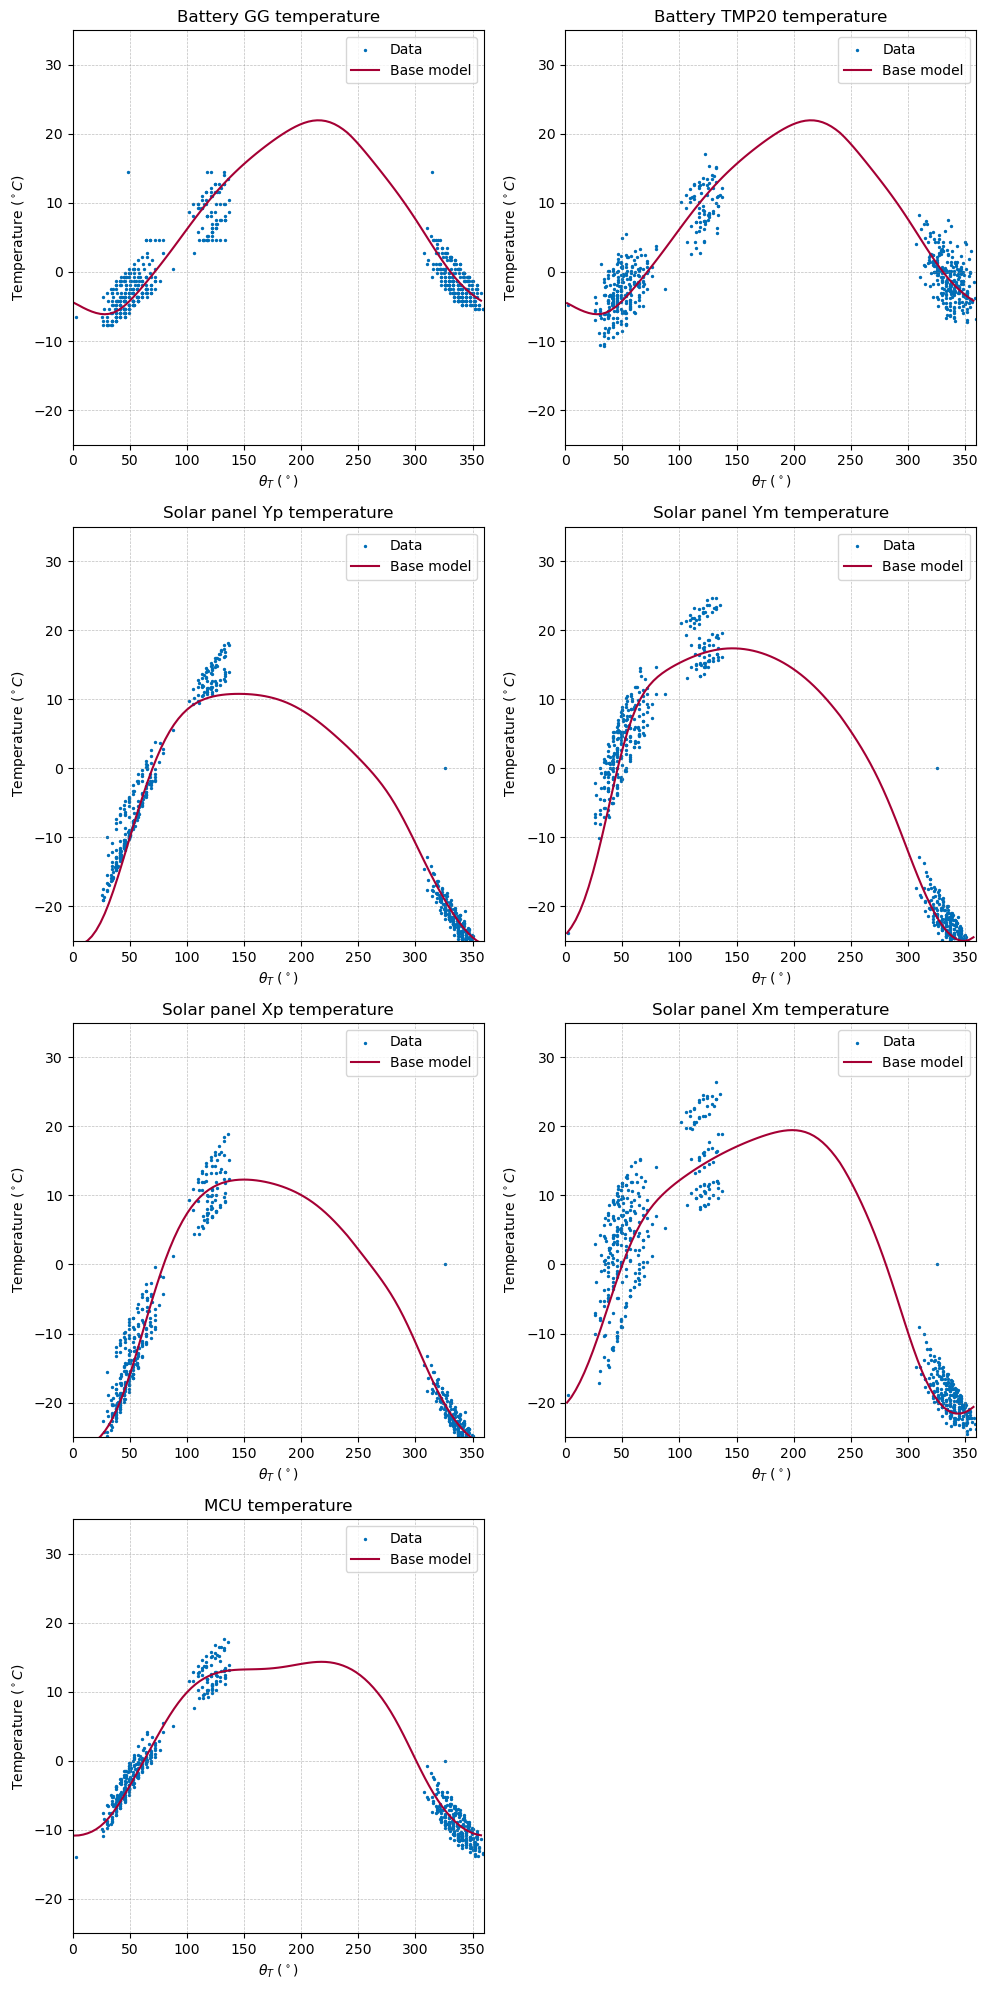

5/5 [==============================] - 0s 39ms/step


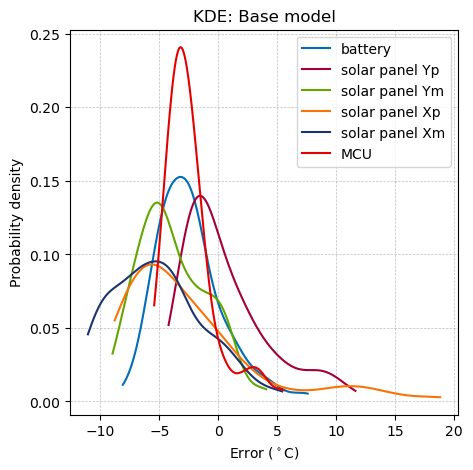

Battery:
Mean: -2.42 degC Std: 2.81 degC (area: 0.99)
Solar panel Yp:
Mean: 0.61 degC Std: 3.60 degC (area: 0.94)
Solar panel Ym:
Mean: -3.81 degC Std: 2.92 degC (area: 0.96)
Solar panel Xp:
Mean: -2.53 degC Std: 5.79 degC (area: 0.90)
Solar panel Xm:
Mean: -5.08 degC Std: 3.83 degC (area: 0.94)
MCU:
Mean: -2.42 degC Std: 2.14 degC (area: 0.95)


Probability of error within 1 degC:
Battery: 0.14
Solar panel Yp: 0.22
Solar panel Ym: 0.13
Solar panel Xp: 0.09
Solar panel Xm: 0.08
MCU: 0.09


In [84]:
artificial_y = model_cleaned_base.predict(artificial_x)

theta_T_data = telem_df["theta_T (deg)"].to_numpy()
temp_data = telem_df[
    [
        "battery GG temperature (deg C)",
        "battery TMP20 temperature (deg C)",
        "solar panel Yp temperature (deg C)",
        "solar panel Ym temperature (deg C)",
        "solar panel Xp temperature (deg C)",
        "solar panel Xm temperature (deg C)",
        "MCU temperature (deg C)",
    ]
].to_numpy()

theta_T_model = artificial_df["theta_T"].to_numpy()
temp_model = artificial_y * (max_temp - min_temp) + min_temp

plot_model(
    theta_T_data=train_cleaned_df["theta_T (deg)"].to_numpy(dtype=np.float64),
    theta_T_model=theta_T_model,
    temp_data=(train_cleaned_df.iloc[:, 6:].to_numpy(dtype=np.float64) * (max_temp - min_temp) + min_temp),
    temp_model=temp_model,
    limit_axis=((0, 360), (-25, 35))
)

y_pred_base_cleaned = model_cleaned_base.predict(test_cleaned_base_x)
residuals = (test_cleaned_base_y - y_pred_base_cleaned) * (max_temp - min_temp)
base_cleaned_stats = kde(residuals, plt_title="KDE: Base model", return_stats=True)

[========================================] 582/582 [100%] in 0.8s (731.05/s)                                            
[========================================] 137/137 [100%] in 0.1s (818.70/s)                                            
Epoch 1/5000
12/12 [==============================] - 1s 29ms/step - loss: 0.0010 - mean_absolute_error: 0.0230 - val_loss: 0.0027 - val_mean_absolute_error: 0.0444
Epoch 2/5000
12/12 [==============================] - 0s 11ms/step - loss: 8.2789e-04 - mean_absolute_error: 0.0211 - val_loss: 0.0032 - val_mean_absolute_error: 0.0488
Epoch 3/5000
12/12 [==============================] - 0s 10ms/step - loss: 7.8858e-04 - mean_absolute_error: 0.0205 - val_loss: 0.0031 - val_mean_absolute_error: 0.0476
Epoch 4/5000
12/12 [==============================] - 0s 10ms/step - loss: 7.6370e-04 - mean_absolute_error: 0.0199 - val_loss: 0.0028 - val_mean_absolute_error: 0.0448
Epoch 5/5000
12/12 [==============================] - 0s 10ms/step - loss: 7.4617e-04 

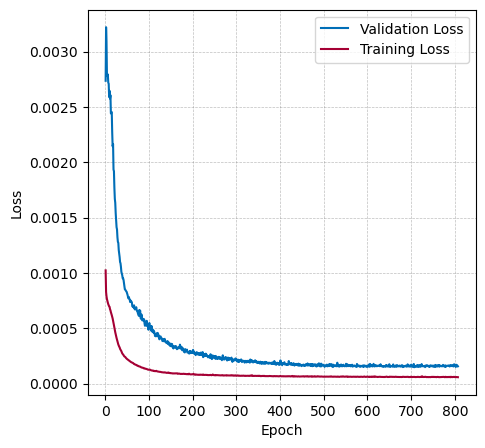

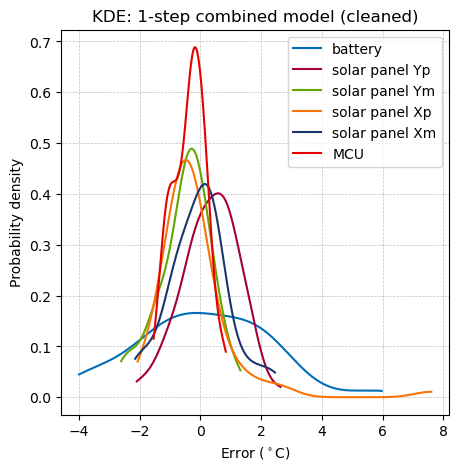

Battery:
Mean: 0.09 degC Std: 2.13 degC (area: 0.95)
Solar panel Yp:
Mean: 0.34 degC Std: 0.91 degC (area: 0.98)
Solar panel Ym:
Mean: -0.52 degC Std: 0.86 degC (area: 0.96)
Solar panel Xp:
Mean: -0.21 degC Std: 1.28 degC (area: 0.96)
Solar panel Xm:
Mean: -0.06 degC Std: 1.01 degC (area: 0.95)
MCU:
Mean: -0.37 degC Std: 0.55 degC (area: 0.96)


Probability of error within 1 degC:
Battery: 0.32
Solar panel Yp: 0.64
Solar panel Ym: 0.68
Solar panel Xp: 0.65
Solar panel Xm: 0.67
MCU: 0.80


In [85]:
# Creating a cleaned_residual model with the previous temperature as input:
# Step size: 1 previous input
step_size = 1
cleaned_base_model_predictions = model_cleaned_base.predict(train_cleaned_base_x, verbose=0)
train_cleaned_res_1_df = window_data_res(train_cleaned_df, cleaned_base_model_predictions, step_size).dropna(how='all').reset_index(drop=True)
train_cleaned_res_1_x = np.empty(shape=(len(train_cleaned_res_1_df), 1 + 6 * (step_size + 1)))
train_cleaned_res_1_y = np.empty(shape=(len(train_cleaned_res_1_df), 6))
for i in range(len(train_cleaned_res_1_df)):
    train_cleaned_res_1_x[i, 0] = train_cleaned_res_1_df["illumination"][i]
    train_cleaned_res_1_x[i, 1:(1 + 6 * step_size)] = train_cleaned_res_1_df.iloc[i, 2:(2 + 6 * step_size)].values
    train_cleaned_res_1_x[i, (1 + 6 * step_size):(7 + 6 * step_size)] = train_cleaned_res_1_df.iloc[i, -12:-6].values

    train_cleaned_res_1_y[i, 0:] = train_cleaned_res_1_df.iloc[i, -6:].values - train_cleaned_res_1_df.iloc[i, -12:-6].values

cleaned_base_model_predictions = model_cleaned_base.predict(test_cleaned_base_x, verbose=0)
test_cleaned_res_1_df = window_data_res(test_cleaned_df, cleaned_base_model_predictions, step_size).dropna(how='all').reset_index(drop=True)
test_cleaned_res_1_x = np.empty(shape=(len(test_cleaned_res_1_df), 1 + 6 * (step_size + 1)))
test_cleaned_res_1_y = np.empty(shape=(len(test_cleaned_res_1_df), 6))
for i in range(len(test_cleaned_res_1_df)):
    test_cleaned_res_1_x[i, 0] = test_cleaned_res_1_df["illumination"][i]
    test_cleaned_res_1_x[i, 1:(1 + 6 * step_size)] = test_cleaned_res_1_df.iloc[i, 2:(2 + 6 * step_size)].values
    test_cleaned_res_1_x[i, (1 + 6 * step_size):(7 + 6 * step_size)] = test_cleaned_res_1_df.iloc[i, -12:-6].values

    test_cleaned_res_1_y[i, 0:] = test_cleaned_res_1_df.iloc[i, -6:].values - test_cleaned_res_1_df.iloc[i, -12:-6].values

# Create cleaned_residual correction model
model_cleaned_res_1 = tf.keras.Sequential()
model_cleaned_res_1.add(tf.keras.layers.Dense(256, activation="relu", input_shape=(1 + 6 * (step_size + 1),)))
model_cleaned_res_1.add(tf.keras.layers.Dense(256, activation="relu"))
model_cleaned_res_1.add(tf.keras.layers.Dense(128, activation="relu"))
model_cleaned_res_1.add(tf.keras.layers.Dense(128, activation="relu"))
model_cleaned_res_1.add(tf.keras.layers.Dense(64, activation="relu"))
model_cleaned_res_1.add(tf.keras.layers.Dense(32, activation="relu"))
model_cleaned_res_1.add(tf.keras.layers.Dense(16, activation="relu"))
model_cleaned_res_1.add(tf.keras.layers.Dense(6, activation="linear"))

model_cleaned_res_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=4e-5),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=100,
    restore_best_weights=True
)

history_97_cleaned_res = model_cleaned_res_1.fit(
    train_cleaned_res_1_x,
    train_cleaned_res_1_y,
    epochs=5000,
    validation_data=(test_cleaned_res_1_x, test_cleaned_res_1_y),
    callbacks=[early_stopping],
)

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_97_cleaned_res.history["loss"]), len(history_97_cleaned_res.history["loss"])),
    history_97_cleaned_res.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_97_cleaned_res.history["loss"]), len(history_97_cleaned_res.history["loss"])),
    history_97_cleaned_res.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Checking the accuracy of the combined model:
y_cleaned_base = test_cleaned_res_1_df.iloc[:, -12:-6].to_numpy(dtype=np.float64)
y_cleaned_res_model = model_cleaned_res_1.predict(test_cleaned_res_1_x, verbose=0)
y_combined = (y_cleaned_base + y_cleaned_res_model) * (max_temp - min_temp) + min_temp

y_actual = test_cleaned_res_1_df.iloc[:, -6:].to_numpy(dtype=np.float64) * (max_temp - min_temp) + min_temp

y_cleaned_res = y_actual - y_combined

cleaned_res_1_stats = kde(y_cleaned_res, plt_title="KDE: 1-step combined model (cleaned)", return_stats=True)

[========================================] 581/581 [100%] in 0.8s (851.05/s)                                            
[========================================] 136/136 [100%] in 0.1s (1743.58/s)                                           
Epoch 1/5000
8/8 [==============================] - 1s 40ms/step - loss: 8.2183e-04 - mean_absolute_error: 0.0208 - val_loss: 0.0030 - val_mean_absolute_error: 0.0467
Epoch 2/5000
8/8 [==============================] - 0s 11ms/step - loss: 7.5490e-04 - mean_absolute_error: 0.0199 - val_loss: 0.0028 - val_mean_absolute_error: 0.0457
Epoch 3/5000
8/8 [==============================] - 0s 11ms/step - loss: 7.2487e-04 - mean_absolute_error: 0.0195 - val_loss: 0.0028 - val_mean_absolute_error: 0.0452
Epoch 4/5000
8/8 [==============================] - 0s 10ms/step - loss: 7.0631e-04 - mean_absolute_error: 0.0192 - val_loss: 0.0028 - val_mean_absolute_error: 0.0452
Epoch 5/5000
8/8 [==============================] - 0s 14ms/step - loss: 6.9422e-04 - mean

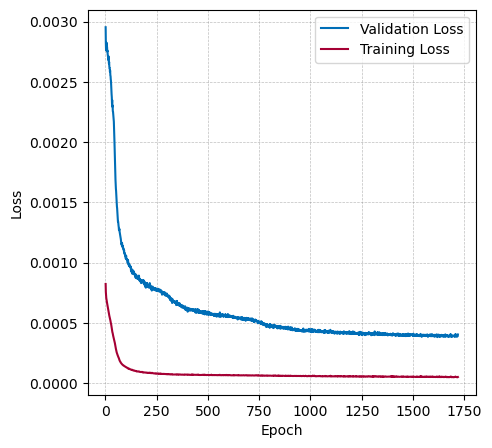

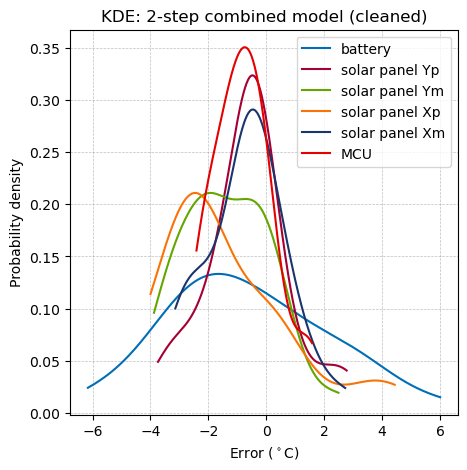

Battery:
Mean: -0.66 degC Std: 2.73 degC (area: 0.95)
Solar panel Yp:
Mean: -0.63 degC Std: 1.42 degC (area: 0.94)
Solar panel Ym:
Mean: -1.36 degC Std: 1.49 degC (area: 0.93)
Solar panel Xp:
Mean: -1.36 degC Std: 2.13 degC (area: 0.87)
Solar panel Xm:
Mean: -0.72 degC Std: 1.37 degC (area: 0.92)
MCU:
Mean: -0.78 degC Std: 1.03 degC (area: 0.89)


Probability of error within 1 degC:
Battery: 0.22
Solar panel Yp: 0.49
Solar panel Ym: 0.34
Solar panel Xp: 0.21
Solar panel Xm: 0.47
MCU: 0.48


In [86]:
# Creating a cleaned_residual model with the previous temperature as input:
# Step size: 1 previous input
step_size = 2
cleaned_base_model_predictions = model_cleaned_base.predict(train_cleaned_base_x, verbose=0)
train_cleaned_res_2_df = window_data_res(train_cleaned_df, cleaned_base_model_predictions, step_size).dropna(how='all').reset_index(drop=True)
train_cleaned_res_2_x = np.empty(shape=(len(train_cleaned_res_2_df), 1 + 6 * (step_size + 1)))
train_cleaned_res_2_y = np.empty(shape=(len(train_cleaned_res_2_df), 6))
for i in range(len(train_cleaned_res_2_df)):
    train_cleaned_res_2_x[i, 0] = train_cleaned_res_2_df["illumination"][i]
    train_cleaned_res_2_x[i, 1:(1 + 6 * step_size)] = train_cleaned_res_2_df.iloc[i, 2:(2 + 6 * step_size)].values
    train_cleaned_res_2_x[i, (1 + 6 * step_size):(7 + 6 * step_size)] = train_cleaned_res_2_df.iloc[i, -12:-6].values

    train_cleaned_res_2_y[i, 0:] = train_cleaned_res_2_df.iloc[i, -6:].values - train_cleaned_res_2_df.iloc[i, -12:-6].values

cleaned_base_model_predictions = model_cleaned_base.predict(test_cleaned_base_x, verbose=0)
test_cleaned_res_2_df = window_data_res(test_cleaned_df, cleaned_base_model_predictions, step_size).dropna(how='all').reset_index(drop=True)
test_cleaned_res_2_x = np.empty(shape=(len(test_cleaned_res_2_df), 1 + 6 * (step_size + 1)))
test_cleaned_res_2_y = np.empty(shape=(len(test_cleaned_res_2_df), 6))
for i in range(len(test_cleaned_res_2_df)):
    test_cleaned_res_2_x[i, 0] = test_cleaned_res_2_df["illumination"][i]
    test_cleaned_res_2_x[i, 1:(1 + 6 * step_size)] = test_cleaned_res_2_df.iloc[i, 2:(2 + 6 * step_size)].values
    test_cleaned_res_2_x[i, (1 + 6 * step_size):(7 + 6 * step_size)] = test_cleaned_res_2_df.iloc[i, -12:-6].values

    test_cleaned_res_2_y[i, 0:] = test_cleaned_res_2_df.iloc[i, -6:].values - test_cleaned_res_2_df.iloc[i, -12:-6].values

# Create cleaned_residual correction model
model_cleaned_res_2 = tf.keras.Sequential()
model_cleaned_res_2.add(tf.keras.layers.Dense(256, activation="relu", input_shape=(1 + 6 * (step_size + 1),)))
model_cleaned_res_2.add(tf.keras.layers.Dense(256, activation="relu"))
model_cleaned_res_2.add(tf.keras.layers.Dense(128, activation="relu"))
model_cleaned_res_2.add(tf.keras.layers.Dense(128, activation="relu"))
model_cleaned_res_2.add(tf.keras.layers.Dense(64, activation="relu"))
model_cleaned_res_2.add(tf.keras.layers.Dense(32, activation="relu"))
model_cleaned_res_2.add(tf.keras.layers.Dense(16, activation="relu"))
model_cleaned_res_2.add(tf.keras.layers.Dense(6, activation="linear"))

model_cleaned_res_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=4e-5),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=100,
    restore_best_weights=True
)

history_97_cleaned_res = model_cleaned_res_2.fit(
    train_cleaned_res_2_x,
    train_cleaned_res_2_y,
    epochs=5000,
    validation_data=(test_cleaned_res_2_x, test_cleaned_res_2_y),
    callbacks=[early_stopping],
)

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_97_cleaned_res.history["loss"]), len(history_97_cleaned_res.history["loss"])),
    history_97_cleaned_res.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_97_cleaned_res.history["loss"]), len(history_97_cleaned_res.history["loss"])),
    history_97_cleaned_res.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Checking the accuracy of the combined model:
y_cleaned_base = test_cleaned_res_2_df.iloc[:, -12:-6].to_numpy(dtype=np.float64)
y_cleaned_res_model = model_cleaned_res_2.predict(test_cleaned_res_2_x, verbose=0)
y_combined = (y_cleaned_base + y_cleaned_res_model) * (max_temp - min_temp) + min_temp

y_actual = test_cleaned_res_2_df.iloc[:, -6:].to_numpy(dtype=np.float64) * (max_temp - min_temp) + min_temp

y_cleaned_res = y_actual - y_combined

cleaned_res_2_stats = kde(y_cleaned_res, plt_title="KDE: 2-step combined model (cleaned)", return_stats=True)

[========================================] 580/580 [100%] in 0.7s (934.26/s)                                            
[========================================] 135/135 [100%] in 0.1s (2386.26/s)                                           
Epoch 1/5000
6/6 [==============================] - 1s 54ms/step - loss: 9.4864e-04 - mean_absolute_error: 0.0221 - val_loss: 0.0018 - val_mean_absolute_error: 0.0337
Epoch 2/5000
6/6 [==============================] - 0s 12ms/step - loss: 8.2810e-04 - mean_absolute_error: 0.0206 - val_loss: 0.0018 - val_mean_absolute_error: 0.0348
Epoch 3/5000
6/6 [==============================] - 0s 13ms/step - loss: 7.9143e-04 - mean_absolute_error: 0.0200 - val_loss: 0.0018 - val_mean_absolute_error: 0.0354
Epoch 4/5000
6/6 [==============================] - 0s 13ms/step - loss: 7.7529e-04 - mean_absolute_error: 0.0197 - val_loss: 0.0018 - val_mean_absolute_error: 0.0356
Epoch 5/5000
6/6 [==============================] - 0s 14ms/step - loss: 7.6018e-04 - mean

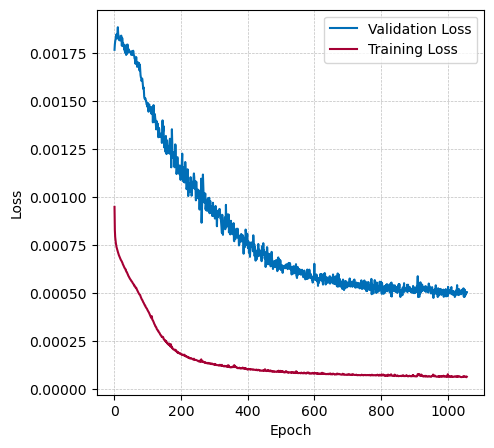

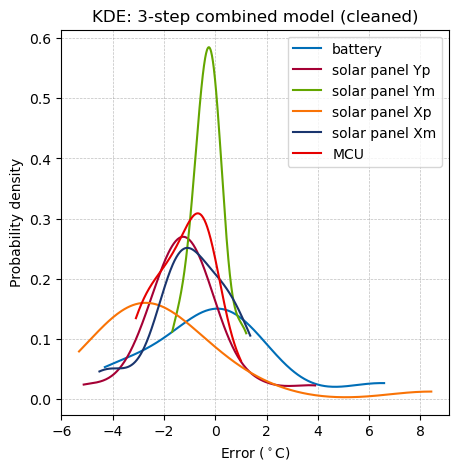

Battery:
Mean: 0.05 degC Std: 2.87 degC (area: 0.86)
Solar panel Yp:
Mean: -1.10 degC Std: 1.76 degC (area: 0.94)
Solar panel Ym:
Mean: -0.27 degC Std: 0.69 degC (area: 0.91)
Solar panel Xp:
Mean: -1.81 degC Std: 2.96 degC (area: 0.87)
Solar panel Xm:
Mean: -0.98 degC Std: 1.49 degC (area: 0.89)
MCU:
Mean: -1.21 degC Std: 1.10 degC (area: 0.88)


Probability of error within 1 degC:
Battery: 0.29
Solar panel Yp: 0.32
Solar panel Ym: 0.76
Solar panel Xp: 0.17
Solar panel Xm: 0.41
MCU: 0.42


In [87]:
step_size = 3
cleaned_base_model_predictions = model_cleaned_base.predict(train_cleaned_base_x, verbose=0)
train_cleaned_res_3_df = window_data_res(train_cleaned_df, cleaned_base_model_predictions, step_size).dropna(how='all').reset_index(drop=True)
train_cleaned_res_3_x = np.empty(shape=(len(train_cleaned_res_3_df), 1 + 6 * (step_size + 1)))
train_cleaned_res_3_y = np.empty(shape=(len(train_cleaned_res_3_df), 6))
for i in range(len(train_cleaned_res_3_df)):
    train_cleaned_res_3_x[i, 0] = train_cleaned_res_3_df["illumination"][i]
    train_cleaned_res_3_x[i, 1:(1 + 6 * step_size)] = train_cleaned_res_3_df.iloc[i, 2:(2 + 6 * step_size)].values
    train_cleaned_res_3_x[i, (1 + 6 * step_size):(7 + 6 * step_size)] = train_cleaned_res_3_df.iloc[i, -12:-6].values

    train_cleaned_res_3_y[i, 0:] = train_cleaned_res_3_df.iloc[i, -6:].values - train_cleaned_res_3_df.iloc[i, -12:-6].values

cleaned_base_model_predictions = model_cleaned_base.predict(test_cleaned_base_x, verbose=0)
test_cleaned_res_3_df = window_data_res(test_cleaned_df, cleaned_base_model_predictions, step_size).dropna(how='all').reset_index(drop=True)
test_cleaned_res_3_x = np.empty(shape=(len(test_cleaned_res_3_df), 1 + 6 * (step_size + 1)))
test_cleaned_res_3_y = np.empty(shape=(len(test_cleaned_res_3_df), 6))
for i in range(len(test_cleaned_res_3_df)):
    test_cleaned_res_3_x[i, 0] = test_cleaned_res_3_df["illumination"][i]
    test_cleaned_res_3_x[i, 1:(1 + 6 * step_size)] = test_cleaned_res_3_df.iloc[i, 2:(2 + 6 * step_size)].values
    test_cleaned_res_3_x[i, (1 + 6 * step_size):(7 + 6 * step_size)] = test_cleaned_res_3_df.iloc[i, -12:-6].values

    test_cleaned_res_3_y[i, 0:] = test_cleaned_res_3_df.iloc[i, -6:].values - test_cleaned_res_3_df.iloc[i, -12:-6].values

# Create cleaned_residual correction model
model_cleaned_res_3 = tf.keras.Sequential()
model_cleaned_res_3.add(tf.keras.layers.Dense(256, activation="relu", input_shape=(1 + 6 * (step_size + 1),)))
model_cleaned_res_3.add(tf.keras.layers.Dense(256, activation="relu"))
model_cleaned_res_3.add(tf.keras.layers.Dense(128, activation="relu"))
model_cleaned_res_3.add(tf.keras.layers.Dense(128, activation="relu"))
model_cleaned_res_3.add(tf.keras.layers.Dense(64, activation="relu"))
model_cleaned_res_3.add(tf.keras.layers.Dense(32, activation="relu"))
model_cleaned_res_3.add(tf.keras.layers.Dense(16, activation="relu"))
model_cleaned_res_3.add(tf.keras.layers.Dense(6, activation="linear"))

model_cleaned_res_3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=4e-5),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=100,
    restore_best_weights=True
)

history_97_cleaned_res = model_cleaned_res_3.fit(
    train_cleaned_res_3_x,
    train_cleaned_res_3_y,
    epochs=5000,
    validation_data=(test_cleaned_res_3_x, test_cleaned_res_3_y),
    callbacks=[early_stopping],
)

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_97_cleaned_res.history["loss"]), len(history_97_cleaned_res.history["loss"])),
    history_97_cleaned_res.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_97_cleaned_res.history["loss"]), len(history_97_cleaned_res.history["loss"])),
    history_97_cleaned_res.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Checking the accuracy of the combined model:
y_cleaned_base = test_cleaned_res_3_df.iloc[:, -12:-6].to_numpy(dtype=np.float64)
y_cleaned_res_model = model_cleaned_res_3.predict(test_cleaned_res_3_x, verbose=0)
y_combined = (y_cleaned_base + y_cleaned_res_model) * (max_temp - min_temp) + min_temp

y_actual = test_cleaned_res_3_df.iloc[:, -6:].to_numpy(dtype=np.float64) * (max_temp - min_temp) + min_temp

y_cleaned_res = y_actual - y_combined

cleaned_res_3_stats = kde(y_cleaned_res, plt_title="KDE: 3-step combined model (cleaned)", return_stats=True)

[========================================] 579/579 [100%] in 0.4s (1719.45/s)                                           
[========================================] 134/134 [100%] in 0.1s (4624.40/s)                                           
Epoch 1/5000
4/4 [==============================] - 1s 89ms/step - loss: 0.0011 - mean_absolute_error: 0.0240 - val_loss: 0.0011 - val_mean_absolute_error: 0.0266
Epoch 2/5000
4/4 [==============================] - 0s 26ms/step - loss: 8.9576e-04 - mean_absolute_error: 0.0208 - val_loss: 0.0011 - val_mean_absolute_error: 0.0272
Epoch 3/5000
4/4 [==============================] - 0s 21ms/step - loss: 8.3080e-04 - mean_absolute_error: 0.0198 - val_loss: 0.0011 - val_mean_absolute_error: 0.0283
Epoch 4/5000
4/4 [==============================] - 0s 21ms/step - loss: 7.9053e-04 - mean_absolute_error: 0.0192 - val_loss: 0.0012 - val_mean_absolute_error: 0.0294
Epoch 5/5000
4/4 [==============================] - 0s 17ms/step - loss: 7.6580e-04 - mean_abs

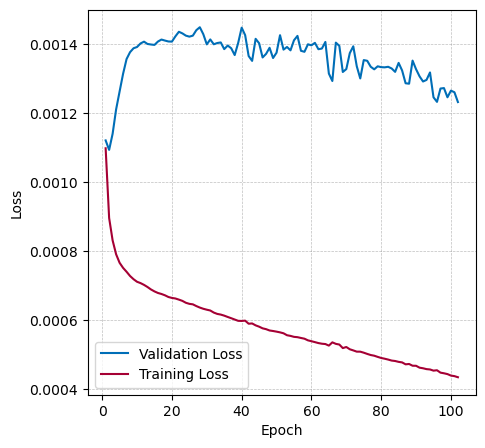

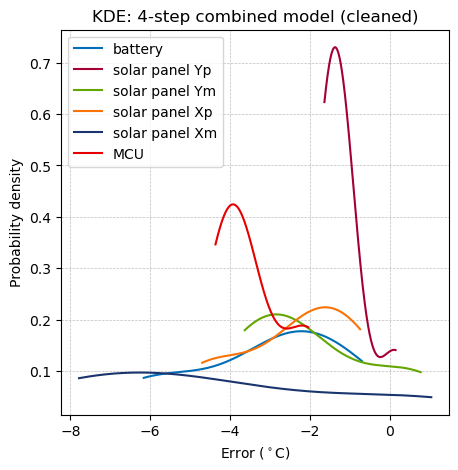

Battery:
Mean: -3.18 degC Std: 1.88 degC (area: 0.73)
Solar panel Yp:
Mean: -1.15 degC Std: 0.56 degC (area: 0.68)
Solar panel Ym:
Mean: -1.88 degC Std: 1.62 degC (area: 0.68)
Solar panel Xp:
Mean: -2.45 degC Std: 1.45 degC (area: 0.69)
Solar panel Xm:
Mean: -4.25 degC Std: 3.37 degC (area: 0.66)
MCU:
Mean: -3.41 degC Std: 0.87 degC (area: 0.67)


Probability of error within 1 degC:
Battery: 0.04
Solar panel Yp: 0.25
Solar panel Ym: 0.20
Solar panel Xp: 0.05
Solar panel Xm: 0.11
MCU: 0.00


In [88]:
step_size = 4
cleaned_base_model_predictions = model_cleaned_base.predict(train_cleaned_base_x, verbose=0)
train_cleaned_res_4_df = window_data_res(train_cleaned_df, cleaned_base_model_predictions, step_size).dropna(how='all').reset_index(drop=True)
train_cleaned_res_4_x = np.empty(shape=(len(train_cleaned_res_4_df), 1 + 6 * (step_size + 1)))
train_cleaned_res_4_y = np.empty(shape=(len(train_cleaned_res_4_df), 6))
for i in range(len(train_cleaned_res_4_df)):
    train_cleaned_res_4_x[i, 0] = train_cleaned_res_4_df["illumination"][i]
    train_cleaned_res_4_x[i, 1:(1 + 6 * step_size)] = train_cleaned_res_4_df.iloc[i, 2:(2 + 6 * step_size)].values
    train_cleaned_res_4_x[i, (1 + 6 * step_size):(7 + 6 * step_size)] = train_cleaned_res_4_df.iloc[i, -12:-6].values

    train_cleaned_res_4_y[i, 0:] = train_cleaned_res_4_df.iloc[i, -6:].values - train_cleaned_res_4_df.iloc[i, -12:-6].values

cleaned_base_model_predictions = model_cleaned_base.predict(test_cleaned_base_x, verbose=0)
test_cleaned_res_4_df = window_data_res(test_cleaned_df, cleaned_base_model_predictions, step_size).dropna(how='all').reset_index(drop=True)
test_cleaned_res_4_x = np.empty(shape=(len(test_cleaned_res_4_df), 1 + 6 * (step_size + 1)))
test_cleaned_res_4_y = np.empty(shape=(len(test_cleaned_res_4_df), 6))
for i in range(len(test_cleaned_res_4_df)):
    test_cleaned_res_4_x[i, 0] = test_cleaned_res_4_df["illumination"][i]
    test_cleaned_res_4_x[i, 1:(1 + 6 * step_size)] = test_cleaned_res_4_df.iloc[i, 2:(2 + 6 * step_size)].values
    test_cleaned_res_4_x[i, (1 + 6 * step_size):(7 + 6 * step_size)] = test_cleaned_res_4_df.iloc[i, -12:-6].values

    test_cleaned_res_4_y[i, 0:] = test_cleaned_res_4_df.iloc[i, -6:].values - test_cleaned_res_4_df.iloc[i, -12:-6].values

# Create cleaned_residual correction model
model_cleaned_res_4 = tf.keras.Sequential()
model_cleaned_res_4.add(tf.keras.layers.Dense(256, activation="relu", input_shape=(1 + 6 * (step_size + 1),)))
model_cleaned_res_4.add(tf.keras.layers.Dense(256, activation="relu"))
model_cleaned_res_4.add(tf.keras.layers.Dense(128, activation="relu"))
model_cleaned_res_4.add(tf.keras.layers.Dense(128, activation="relu"))
model_cleaned_res_4.add(tf.keras.layers.Dense(64, activation="relu"))
model_cleaned_res_4.add(tf.keras.layers.Dense(32, activation="relu"))
model_cleaned_res_4.add(tf.keras.layers.Dense(16, activation="relu"))
model_cleaned_res_4.add(tf.keras.layers.Dense(6, activation="linear"))

model_cleaned_res_4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=4e-5),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=100,
    restore_best_weights=True
)

history_97_cleaned_res = model_cleaned_res_4.fit(
    train_cleaned_res_4_x,
    train_cleaned_res_4_y,
    epochs=5000,
    validation_data=(test_cleaned_res_4_x, test_cleaned_res_4_y),
    callbacks=[early_stopping],
)

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_97_cleaned_res.history["loss"]), len(history_97_cleaned_res.history["loss"])),
    history_97_cleaned_res.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_97_cleaned_res.history["loss"]), len(history_97_cleaned_res.history["loss"])),
    history_97_cleaned_res.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Checking the accuracy of the combined model:
y_cleaned_base = test_cleaned_res_4_df.iloc[:, -12:-6].to_numpy(dtype=np.float64)
y_cleaned_res_model = model_cleaned_res_4.predict(test_cleaned_res_4_x, verbose=0)
y_combined = (y_cleaned_base + y_cleaned_res_model) * (max_temp - min_temp) + min_temp

y_actual = test_cleaned_res_4_df.iloc[:, -6:].to_numpy(dtype=np.float64) * (max_temp - min_temp) + min_temp

y_cleaned_res = y_actual - y_combined

cleaned_res_4_stats = kde(y_cleaned_res, plt_title="KDE: 4-step combined model (cleaned)", return_stats=True)

[========================================] 578/578 [100%] in 0.3s (3092.03/s)                                           
[========================================] 133/133 [100%] in 0.0s (6041.83/s)                                           
Epoch 1/5000
2/2 [==============================] - 1s 235ms/step - loss: 9.1348e-04 - mean_absolute_error: 0.0230 - val_loss: 0.0025 - val_mean_absolute_error: 0.0404
Epoch 2/5000
2/2 [==============================] - 0s 47ms/step - loss: 7.9638e-04 - mean_absolute_error: 0.0210 - val_loss: 0.0025 - val_mean_absolute_error: 0.0420
Epoch 3/5000
2/2 [==============================] - 0s 47ms/step - loss: 7.2648e-04 - mean_absolute_error: 0.0197 - val_loss: 0.0025 - val_mean_absolute_error: 0.0435
Epoch 4/5000
2/2 [==============================] - 0s 32ms/step - loss: 6.7991e-04 - mean_absolute_error: 0.0191 - val_loss: 0.0026 - val_mean_absolute_error: 0.0446
Epoch 5/5000
2/2 [==============================] - 0s 31ms/step - loss: 6.5008e-04 - mea

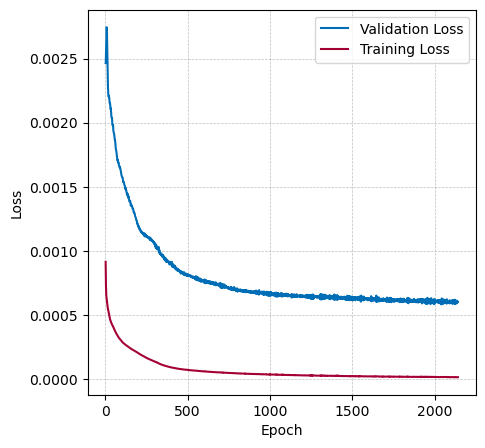

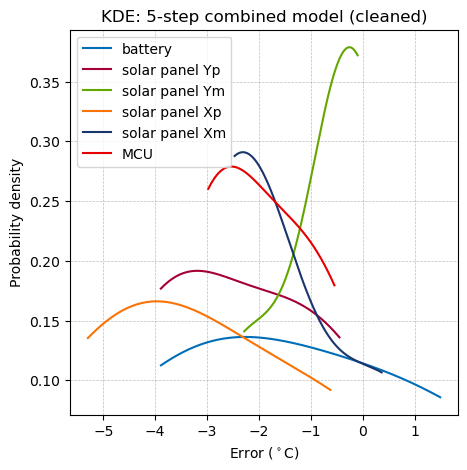

Battery:
Mean: -1.45 degC Std: 2.04 degC (area: 0.65)
Solar panel Yp:
Mean: -2.39 degC Std: 1.40 degC (area: 0.60)
Solar panel Ym:
Mean: -0.75 degC Std: 0.90 degC (area: 0.54)
Solar panel Xp:
Mean: -3.25 degC Std: 1.74 degC (area: 0.66)
Solar panel Xm:
Mean: -1.67 degC Std: 1.18 degC (area: 0.53)
MCU:
Mean: -1.98 degC Std: 0.99 degC (area: 0.60)


Probability of error within 1 degC:
Battery: 0.23
Solar panel Yp: 0.08
Solar panel Ym: 0.31
Solar panel Xp: 0.03
Solar panel Xm: 0.17
MCU: 0.09


In [89]:
step_size = 5
cleaned_base_model_predictions = model_cleaned_base.predict(train_cleaned_base_x, verbose=0)
train_cleaned_res_5_df = window_data_res(train_cleaned_df, cleaned_base_model_predictions, step_size).dropna(how='all').reset_index(drop=True)
train_cleaned_res_5_x = np.empty(shape=(len(train_cleaned_res_5_df), 1 + 6 * (step_size + 1)))
train_cleaned_res_5_y = np.empty(shape=(len(train_cleaned_res_5_df), 6))
for i in range(len(train_cleaned_res_5_df)):
    train_cleaned_res_5_x[i, 0] = train_cleaned_res_5_df["illumination"][i]
    train_cleaned_res_5_x[i, 1:(1 + 6 * step_size)] = train_cleaned_res_5_df.iloc[i, 2:(2 + 6 * step_size)].values
    train_cleaned_res_5_x[i, (1 + 6 * step_size):(7 + 6 * step_size)] = train_cleaned_res_5_df.iloc[i, -12:-6].values

    train_cleaned_res_5_y[i, 0:] = train_cleaned_res_5_df.iloc[i, -6:].values - train_cleaned_res_5_df.iloc[i, -12:-6].values

cleaned_base_model_predictions = model_cleaned_base.predict(test_cleaned_base_x, verbose=0)
test_cleaned_res_5_df = window_data_res(test_cleaned_df, cleaned_base_model_predictions, step_size).dropna(how='all').reset_index(drop=True)
test_cleaned_res_5_x = np.empty(shape=(len(test_cleaned_res_5_df), 1 + 6 * (step_size + 1)))
test_cleaned_res_5_y = np.empty(shape=(len(test_cleaned_res_5_df), 6))
for i in range(len(test_cleaned_res_5_df)):
    test_cleaned_res_5_x[i, 0] = test_cleaned_res_5_df["illumination"][i]
    test_cleaned_res_5_x[i, 1:(1 + 6 * step_size)] = test_cleaned_res_5_df.iloc[i, 2:(2 + 6 * step_size)].values
    test_cleaned_res_5_x[i, (1 + 6 * step_size):(7 + 6 * step_size)] = test_cleaned_res_5_df.iloc[i, -12:-6].values

    test_cleaned_res_5_y[i, 0:] = test_cleaned_res_5_df.iloc[i, -6:].values - test_cleaned_res_5_df.iloc[i, -12:-6].values

# Create cleaned_residual correction model
model_cleaned_res_5 = tf.keras.Sequential()
model_cleaned_res_5.add(tf.keras.layers.Dense(256, activation="relu", input_shape=(1 + 6 * (step_size + 1),)))
model_cleaned_res_5.add(tf.keras.layers.Dense(256, activation="relu"))
model_cleaned_res_5.add(tf.keras.layers.Dense(128, activation="relu"))
model_cleaned_res_5.add(tf.keras.layers.Dense(128, activation="relu"))
model_cleaned_res_5.add(tf.keras.layers.Dense(64, activation="relu"))
model_cleaned_res_5.add(tf.keras.layers.Dense(32, activation="relu"))
model_cleaned_res_5.add(tf.keras.layers.Dense(16, activation="relu"))
model_cleaned_res_5.add(tf.keras.layers.Dense(6, activation="linear"))

model_cleaned_res_5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=4e-5),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=100,
    restore_best_weights=True
)

history_97_cleaned_res = model_cleaned_res_5.fit(
    train_cleaned_res_5_x,
    train_cleaned_res_5_y,
    epochs=5000,
    validation_data=(test_cleaned_res_5_x, test_cleaned_res_5_y),
    callbacks=[early_stopping],
)

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_97_cleaned_res.history["loss"]), len(history_97_cleaned_res.history["loss"])),
    history_97_cleaned_res.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_97_cleaned_res.history["loss"]), len(history_97_cleaned_res.history["loss"])),
    history_97_cleaned_res.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Checking the accuracy of the combined model:
y_cleaned_base = test_cleaned_res_5_df.iloc[:, -12:-6].to_numpy(dtype=np.float64)
y_cleaned_res_model = model_cleaned_res_5.predict(test_cleaned_res_5_x, verbose=0)
y_combined = (y_cleaned_base + y_cleaned_res_model) * (max_temp - min_temp) + min_temp

y_actual = test_cleaned_res_5_df.iloc[:, -6:].to_numpy(dtype=np.float64) * (max_temp - min_temp) + min_temp

y_cleaned_res = y_actual - y_combined

cleaned_res_5_stats = kde(y_cleaned_res, plt_title="KDE: 5-step combined model (cleaned)", return_stats=True)

In [90]:
# Tabulating the stats of base and residual models:
cleaned_stats_df = pd.DataFrame(
    columns=[
        "Model",
        "Battery error mean (deg C)",
        "Battery error std (deg C)",
        "Battery 1 deg C error %",
        "Yp panel error mean (deg C)",
        "Yp panel error std (deg C)",
        "Yp panel 1 deg C error %",
        "Ym panel error mean (deg C)",
        "Ym panel error std (deg C)",
        "Ym panel 1 deg C error %",
        "Xp panel error mean (deg C)",
        "Xp panel error std (deg C)",
        "Xp panel 1 deg C error %",
        "Xm panel error mean (deg C)",
        "Xm panel error std (deg C)",
        "Xm panel 1 deg C error %",
        "MCU error mean (deg C)",
        "MCU error std (deg C)",
        "MCU 1 deg C error %",
    ]
)

cleaned_stats_df.loc[0, "Model"] = "Base model"
point = 1
for i in range(6):
    for j in range(3):
        cleaned_stats_df.iloc[0, point] = base_cleaned_stats[0][j][i]
        point += 1

cleaned_stats_df.loc[1, "Model"] = "1-step model"
point = 1
for i in range(6):
    for j in range(3):
        cleaned_stats_df.iloc[1, point] = cleaned_res_1_stats[0][j][i]
        point += 1

cleaned_stats_df.loc[2, "Model"] = "2-step model"
point = 1
for i in range(6):
    for j in range(3):
        cleaned_stats_df.iloc[2, point] = cleaned_res_2_stats[0][j][i]
        point += 1

cleaned_stats_df.loc[3, "Model"] = "3-step model"
point = 1
for i in range(6):
    for j in range(3):
        cleaned_stats_df.iloc[3, point] = cleaned_res_3_stats[0][j][i]
        point += 1

cleaned_stats_df.loc[4, "Model"] = "4-step model"
point = 1
for i in range(6):
    for j in range(3):
        cleaned_stats_df.iloc[4, point] = cleaned_res_4_stats[0][j][i]
        point += 1

cleaned_stats_df.loc[5, "Model"] = "5-step model"
point = 1
for i in range(6):
    for j in range(3):
        cleaned_stats_df.iloc[5, point] = cleaned_res_5_stats[0][j][i]
        point += 1


In [94]:
print(cleaned_stats_df.iloc[0, 1])

-2.417920004911181


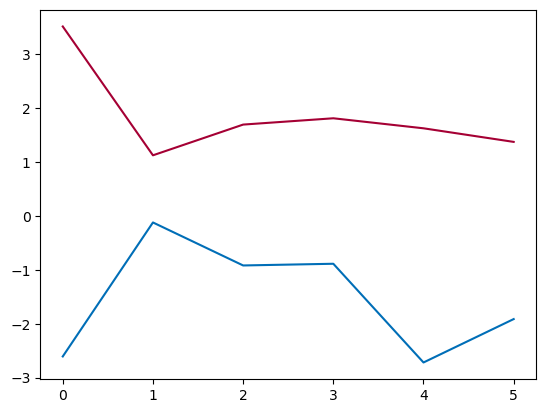

In [97]:
step_sizes = [0, 1, 2, 3, 4, 5]
mean = [0, 0, 0, 0, 0, 0]
std = [0, 0, 0, 0, 0, 0]
for i in step_sizes:
    mean[i] = np.mean([cleaned_stats_df.iloc[i, 1], cleaned_stats_df.iloc[i, 4], cleaned_stats_df.iloc[i, 7], cleaned_stats_df.iloc[i, 10], cleaned_stats_df.iloc[i, 13], cleaned_stats_df.iloc[i, 16]])
    std[i] = np.mean([cleaned_stats_df.iloc[i, 2], cleaned_stats_df.iloc[i, 5], cleaned_stats_df.iloc[i, 8], cleaned_stats_df.iloc[i, 11], cleaned_stats_df.iloc[i, 14], cleaned_stats_df.iloc[i, 17]])

plt.plot(step_sizes, mean, color=plt_colors[0], label="Mean")
plt.plot(step_sizes, std, color=plt_colors[1], label="Std")

[1.00000000e+02 4.67332237e-03 2.39000000e+02]


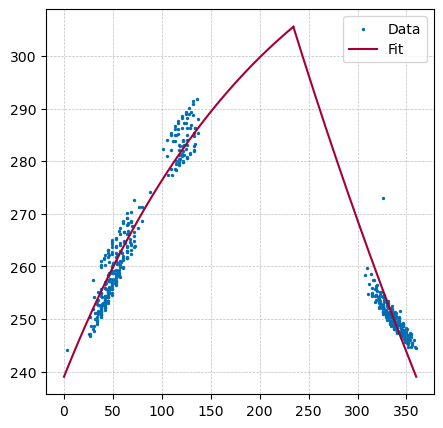

In [91]:
# Creating a fit for the rising side of the temperatures:
fe_mean = np.mean(train_cleaned_df["fe"])
theta_E = 360 * (1 - fe_mean)



x_data_rising = train_cleaned_df["theta_T (deg)"][train_cleaned_df["theta_T (deg)"] < theta_E].to_numpy()
y_data_rising = train_cleaned_df["solar panel Xp temperature (deg C)"][train_cleaned_df["theta_T (deg)"] < theta_E].to_numpy() * (max_temp - min_temp) + min_temp + 273

def rising_fit(x, a, b, c):
    return a * (1 - np.exp(-b * x)) + c

x_data_falling = train_cleaned_df["theta_T (deg)"][train_cleaned_df["theta_T (deg)"] >= theta_E].to_numpy()
y_data_falling = train_cleaned_df["solar panel Xp temperature (deg C)"][train_cleaned_df["theta_T (deg)"] >= theta_E].to_numpy() * (max_temp - min_temp) + min_temp + 273
p0 = (75, 0.1, np.min(y_data_rising))
bounds = ((0, 0, np.min(y_data_rising)-5), (100, 1, np.min(y_data_rising)+5))

popt_rising, pcov = curve_fit(rising_fit, x_data_rising, y_data_rising, p0=p0, bounds=bounds)
a, b, c= popt_rising
print(popt_rising)
peak_temp = a * (1 - np.exp(-b * theta_E)) + c

d = np.log(c / peak_temp) / (theta_E - 360)
# Plotting the fit:
x_fit_rising = np.linspace(0, theta_E, 250)
y_fit_rising = rising_fit(x_fit_rising, *popt_rising)

x_fit_falling = np.linspace(theta_E, 360, 250)
y_fit_falling = peak_temp * np.exp(-d * (x_fit_falling - theta_E))

plt.figure(figsize=(5, 5))
plt.scatter(
    x_data_rising,
    y_data_rising,
    color=plt_colors[0],
    label="Data",
    s=2,
)
plt.scatter(
    x_data_falling,
    y_data_falling,
    color=plt_colors[0],
    s=2,
)
plt.plot(
    x_fit_rising,
    y_fit_rising,
    color=plt_colors[1],
    label="Fit",
)
plt.plot(
    x_fit_falling,
    y_fit_falling,
    color=plt_colors[1],
)
plt.legend()
plt.grid()
plt.show()

[6.31778251e+01 1.36391452e-02 2.34142436e+02 1.58597232e-03]


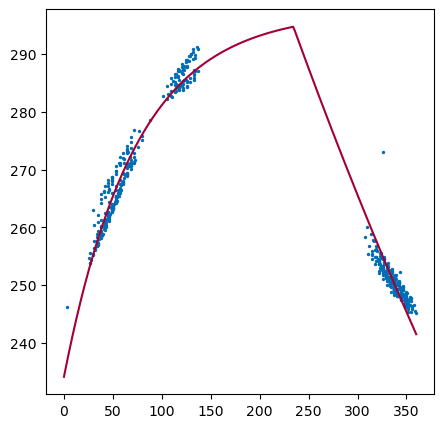

In [92]:


def fit_func(x, a, b, c, d):
    return_array = np.empty(shape=x.shape[0], dtype=np.float64)

    for i, xi in enumerate(x):
        if xi < theta_E:
            return_array[i] = a * (1 - np.exp(-b * xi)) + c
        else:
            return_array[i] = (a * (1 - np.exp(-b * theta_E)) + c) * np.exp(-d * (xi - theta_E))

    return return_array

x_data = train_cleaned_df["theta_T (deg)"].to_numpy()
y_data = train_cleaned_df["solar panel Yp temperature (deg C)"].to_numpy() * (max_temp - min_temp) + min_temp + 273

p0 = [50, 0.1, 0, 0.1 ]
bounds = [[20, 0, 0, 0], [100, 10, 300, 10]]

popt, pcov = curve_fit(fit_func, x_data, y_data, p0=p0, bounds=bounds)

print(popt)
x_fit = np.linspace(0, 360, 250)
y_fit = fit_func(x_fit, *popt)
plt.figure(figsize=(5, 5))
plt.scatter(x_data, y_data, color=plt_colors[0], label="Data", s=2)
plt.plot(x_fit, y_fit, color=plt_colors[1], label="Fit")




C:\Users\ullas\AppData\Local\Temp\ipykernel_22504\808580065.py:8: RuntimeWarning: overflow encountered in exp
  return a * (1 - np.exp(-b * x)) + c
c:\Users\ullas\miniconda3\envs\thesis-env\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


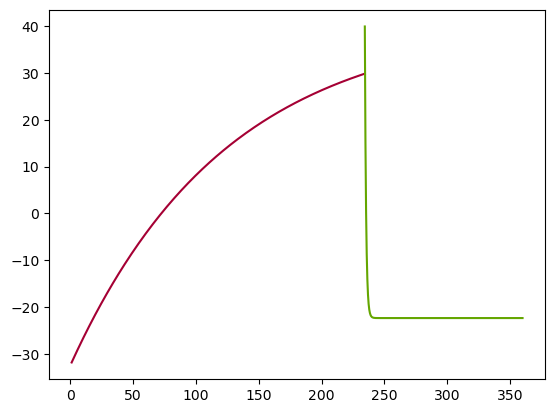

In [93]:
x_data_1 = train_cleaned_df["theta_T (deg)"][train_cleaned_df["theta_T (deg)"] < theta_E].to_numpy()
y_data_1 = train_cleaned_df["solar panel Yp temperature (deg C)"][train_cleaned_df["theta_T (deg)"] < theta_E].to_numpy() * (max_temp - min_temp) + min_temp

x_data_2 = train_cleaned_df["theta_T (deg)"][train_cleaned_df["theta_T (deg)"] >= theta_E].to_numpy(dtype=np.float64)
y_data_2 = train_cleaned_df["solar panel Yp temperature (deg C)"][train_cleaned_df["theta_T (deg)"] >= theta_E].to_numpy(dtype=np.float64) * (max_temp - min_temp) + min_temp

def fit_func_1(x, a, b, c):
    return a * (1 - np.exp(-b * x)) + c

popt, pcov = curve_fit(fit_func_1, x_data_1, y_data_1)

x_fit = np.linspace(1, theta_E, 250)
y_fit = fit_func_1(x_fit, *popt)
plt.plot(x_fit, y_fit, color=plt_colors[1], label="Fit 1")

a, b, c = popt
peak = a * (1 - np.exp(-b * theta_E))

def fit_func_2(x, d, e):
    return peak * np.exp(-d * (x - theta_E)) + e

popt, pcov = curve_fit(fit_func_2, x_data_2, y_data_2)

x_fit = np.linspace(theta_E, 360, 250)
y_fit = fit_func_2(x_fit, *popt)
plt.plot(x_fit, y_fit, color=plt_colors[2], label="Fit 2")

